Predefined functions / class

In [1]:
import os
import dill
from pathlib import Path
import argparse
import sys

# sys.path.append('/scratch/connectome/ycryu/ENIGMA_OCD_MBBN/MBBN-main')
sys.path.append('/pscratch/sd/y/ycryu/ENIGMA_OCD_MBBN/MBBN-main')

from utils import *

def setup_folders(base_path): 
    os.makedirs(os.path.join(base_path,'experiments'),exist_ok=True) 
    os.makedirs(os.path.join(base_path,'runs'),exist_ok=True)
    os.makedirs(os.path.join(base_path, 'splits'), exist_ok=True)
    return None


In [2]:
class Args:
    def __init__(self):
        self.dataset_name = 'ENIGMA_OCD'
        # self.base_path = '/scratch/connectome/ycryu/ENIGMA_OCD_MBBN/MBBN-main' # YC : Should be fixed
        # self.enigma_path = '/scratch/connectome/ycryu/MBBN_data_mini'
        self.base_path = '/pscratch/sd/y/ycryu/ENIGMA_OCD_MBBN/MBBN-main'
        self.enigma_path = '/pscratch/sd/y/ycryu/MBBN_data'
        self.step = '4' # step 4 for testing
        self.fine_tune_task = 'binary_classification'
        self.target = 'OCD'
        self.fmri_type = 'divided_timeseries'
        self.transformer_hidden_layers = 8
        self.seq_part = 'head'
        self.fmri_dividing_type = 'three_channels'
        self.spat_diff_loss_type = 'minus_log'
        self.spatial_loss_factor = 4.0
        self.exp_name = 'test_evaluation_seed101'
        self.seed = 101
        self.intermediate_vec = 316
        self.num_heads = 4
        self.fmri_dividing_type = 'three_channels'
        self.sequence_length_phase4 = 100
        self.distributed = False # True for distributed training
        self.wandb_mode = 'disabled'
        self.lr_warmup_phase4 = 1
        # self.workers_phase1 = 1
        # self.workers_phase2 = 1
        # self.workers_phase3 = 1
        self.workers_phase4 = 1

        ## YC : Should apply to new code
        self.num_forward_pass = 16

In [3]:
def get_arguments(base_path):
    parser = argparse.ArgumentParser()
    parser.add_argument('--exp_name', type=str,default="baseline") 
    parser.add_argument('--dataset_name', type=str, choices=['HCP1200', 'ABCD', 'ABIDE', 'UKB', 'ENIGMA_OCD'], default="ENIGMA_OCD")
    parser.add_argument('--fmri_type', type=str, choices=['timeseries', 'frequency', 'divided_timeseries', 'time_domain_low', 'time_domain_ultralow', 'time_domain_high', 'frequency_domain_low', 'frequency_domain_ultralow', 'frequency_domain_high'], default="divided_timeseries")
    parser.add_argument('--intermediate_vec', type=int, default=400)
    parser.add_argument('--abcd_path', default='/scratch/connectome/stellasybae/ABCD_ROI/7.ROI') ## labserver
    parser.add_argument('--ukb_path', default='/scratch/connectome/stellasybae/UKB_ROI') ## labserver
    parser.add_argument('--abide_path', default='/scratch/connectome/stellasybae/ABIDE_ROI') ## labserver
    parser.add_argument('--enigma_path', default='/pscratch/sd/p/pakmasha/MBBN_data') ## Perlmutter 
    parser.add_argument('--base_path', default=base_path) # where your main.py, train.py, model.py are in.
    parser.add_argument('--step', default='1', choices=['1','2','3','4'], help='which step you want to run') # YC : Step 1 : vanilla_BERT / Step 2 : MBBN / Step 3 : divfreqBERT_reconstruction / Step 4 : test
    
    
    parser.add_argument('--target', type=str, default='OCD')
    parser.add_argument('--fine_tune_task',
                        choices=['regression','binary_classification'],
                        help='fine tune model objective. choose binary_classification in case of a binary classification task')
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--visualization', action='store_true')
    parser.add_argument('--prepare_visualization', action='store_true')
    parser.add_argument('--weightwatcher', action='store_true')
    parser.add_argument('--weightwatcher_save_dir', default=None)

    
    
    parser.add_argument('--norm_axis', default=1, type=int, choices=[0,1,None])
    
    parser.add_argument('--cuda', default=True)
    parser.add_argument('--log_dir', type=str, default=os.path.join(base_path, 'runs'))

    parser.add_argument('--transformer_hidden_layers', type=int,default=8)
    
    # DDP configs:
    parser.add_argument('--world_size', default=-1, type=int, 
                        help='number of nodes for distributed training')
    parser.add_argument('--rank', default=-1, type=int, 
                        help='node rank for distributed training')
    parser.add_argument('--local_rank', default=-1, type=int, 
                        help='local rank for distributed training')
    parser.add_argument('--dist_backend', default='nccl', type=str, 
                        help='distributed backend')
    parser.add_argument('--init_method', default='file', type=str, choices=['file','env'], help='DDP init method')
    parser.add_argument('--distributed', default=True)

    # AMP configs:
    parser.add_argument('--amp', action='store_false')
    parser.add_argument('--gradient_clipping', action='store_true')
    parser.add_argument('--clip_max_norm', type=float, default=1.0)
    
    # Gradient accumulation
    parser.add_argument("--accumulation_steps", default=1, type=int,required=False,help='mini batch size == accumulation_steps * args.train_batch_size')
    
    # Nsight profiling
    parser.add_argument("--profiling", action='store_true')
    
    #wandb related
    parser.add_argument('--wandb_key', default='d0330ca06936eecd637c3470c47af6d33e1cb277', type=str,  help='default: key for ycryu')
    parser.add_argument('--wandb_mode', default='online', type=str,  help='online|offline')
    parser.add_argument('--wandb_entity', default='youngchanryu-seoul-national-university', type=str)
    parser.add_argument('--wandb_project', default='enigma-ocd_mbbn', type=str)

    
    # dividing
    parser.add_argument('--filtering_type', default='Boxcar', choices=['FIR', 'Boxcar'])
    parser.add_argument('--use_high_freq', action='store_true')
    parser.add_argument('--divide_by_lorentzian', action='store_true')
    parser.add_argument('--use_raw_knee', action='store_true')
    parser.add_argument('--seq_part', type=str, default='head')
    parser.add_argument('--fmri_dividing_type', default='three_channels', choices=['two_channels', 'three_channels', 'four_channels'])
    
    # Dropouts
    parser.add_argument('--transformer_dropout_rate', type=float, default=0.3) 

    # Architecture
    parser.add_argument('--num_heads', type=int, default=12,
                        help='number of heads for BERT network (default: 12)')
    parser.add_argument('--attn_mask', action='store_false',
                        help='use attention mask for Transformer (default: true)')
                        
    
    ## for finetune
    parser.add_argument('--pretrained_model_weights_path', default=None)
    parser.add_argument('--finetune', action='store_true')
    parser.add_argument('--finetune_test', action='store_true', help='test phase of finetuning task')
    
    
    ## spatiotemporal
    parser.add_argument('--spatiotemporal', action = 'store_true')
    parser.add_argument('--spat_diff_loss_type', type=str, default='minus_log', choices=['minus_log', 'reciprocal_log', 'exp_minus', 'log_loss', 'exp_whole'])
    parser.add_argument('--spatial_loss_factor', type=float, default=0.1)
    
    ## ablation
    parser.add_argument('--ablation', type=str, choices=['convolution', 'no_high_freq'])
    
    ## YC : Phase means step
    ## phase 1 vanilla BERT
    parser.add_argument('--task_phase1', type=str, default='vanilla_BERT')
    parser.add_argument('--batch_size_phase1', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--validation_frequency_phase1', type=int, default=10000000)
    parser.add_argument('--nEpochs_phase1', type=int, default=2)  # initially, default=100
    parser.add_argument('--optim_phase1', default='AdamW')
    parser.add_argument('--weight_decay_phase1', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase1', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase1', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase1', type=float, default=0.97)
    parser.add_argument('--lr_step_phase1', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase1', type=int, default=500)
    parser.add_argument('--sequence_length_phase1', type=int ,default=300) # ABCD 348 ABIDE 280 UKB 464
    parser.add_argument('--workers_phase1', type=int,default=4)
    parser.add_argument('--num_heads_2DBert', type=int, default=12)
    
    ## phase 2 MBBN
    parser.add_argument('--task_phase2', type=str, default='MBBN')
    parser.add_argument('--batch_size_phase2', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--nEpochs_phase2', type=int, default=100)  # initially, default=100
    parser.add_argument('--optim_phase2', default='AdamW')
    parser.add_argument('--weight_decay_phase2', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase2', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase2', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase2', type=float, default=0.97)
    parser.add_argument('--lr_step_phase2', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase2', type=int, default=500)
    parser.add_argument('--sequence_length_phase2', type=int ,default=300) # ABCD 348 ABIDE 280 UKB 464
    parser.add_argument('--workers_phase2', type=int, default=4)   # default=4
    
    ##phase 3 pretraining
    parser.add_argument('--task_phase3', type=str, default='MBBN_pretraining')
    parser.add_argument('--batch_size_phase3', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--validation_frequency_phase3', type=int, default=10000000)
    parser.add_argument('--nEpochs_phase3', type=int, default=1000)
    parser.add_argument('--optim_phase3', default='AdamW')
    parser.add_argument('--weight_decay_phase3', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase3', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase3', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase3', type=float, default=0.97)
    parser.add_argument('--lr_step_phase3', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase3', type=int, default=500)
    parser.add_argument('--sequence_length_phase3', type=int ,default=300)
    parser.add_argument('--workers_phase3', type=int,default=4)
    parser.add_argument('--use_recon_loss', action='store_true')
    parser.add_argument('--use_mask_loss', action='store_true') 
    parser.add_argument('--use_cont_loss', action='store_true')
    parser.add_argument('--masking_rate', type=float, default=0.1)
    parser.add_argument('--masking_method', type=str, default='spatiotemporal', choices=['temporal', 'spatial', 'spatiotemporal'])
    parser.add_argument('--temporal_masking_type', type=str, default='time_window', choices=['single_point','time_window'])
    parser.add_argument('--temporal_masking_window_size', type=int, default=20)
    parser.add_argument('--window_interval_rate', type=int, default=2)
    parser.add_argument('--spatial_masking_type', type=str, default='random_ROIs', choices=['hub_ROIs', 'random_ROIs'])
    parser.add_argument('--communicability_option', type=str, default='remove_high_comm_node', choices=['remove_high_comm_node', 'remove_low_comm_node'])
    parser.add_argument('--num_hub_ROIs', type=int, default=5)
    parser.add_argument('--num_random_ROIs', type=int, default=5)
    parser.add_argument('--spatiotemporal_masking_type', type=str, default='whole', choices=['whole', 'separate'])
    
    
    ## phase 4 (test)
    parser.add_argument('--task_phase4', type=str, default='test')
    parser.add_argument('--model_weights_path_phase4', default=None)
    parser.add_argument('--batch_size_phase4', type=int, default=4)
    parser.add_argument('--nEpochs_phase4', type=int, default=1)
    parser.add_argument('--optim_phase4', default='AdamW')
    parser.add_argument('--weight_decay_phase4', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase4', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase4', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase4', type=float, default=0.9)
    parser.add_argument('--lr_step_phase4', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase4', type=int, default=100)
    parser.add_argument('--sequence_length_phase4', type=int,default=300) # ABCD 348 ABIDE 280 UKB 464
    parser.add_argument('--workers_phase4', type=int, default=4)

    ## YC : Should apply to new code
    parser.add_argument('--num_forward_pass', type=int, default=16)
                        
    args = parser.parse_args()
        
    return args

In [4]:
args_instance = Args()

sys.argv = [
    'test.ipynb',
    '--dataset_name', args_instance.dataset_name,
    '--base_path', args_instance.base_path,
    '--enigma_path', args_instance.enigma_path,
    '--step', args_instance.step,
    '--fine_tune_task', args_instance.fine_tune_task,
    '--target', args_instance.target,
    '--fmri_type', args_instance.fmri_type,
    '--transformer_hidden_layers', str(args_instance.transformer_hidden_layers),
    '--divide_by_lorentzian', 
    '--seq_part', args_instance.seq_part,
    '--use_raw_knee',
    '--fmri_dividing_type', args_instance.fmri_dividing_type,
    '--use_high_freq',
    '--spatiotemporal',
    '--spat_diff_loss_type', args_instance.spat_diff_loss_type,
    '--spatial_loss_factor', str(args_instance.spatial_loss_factor),
    '--exp_name', args_instance.exp_name,
    '--seed', str(args_instance.seed),
    '--intermediate_vec', str(args_instance.intermediate_vec),
    '--num_heads', str(args_instance.num_heads),
    '--sequence_length_phase4', str(args_instance.sequence_length_phase4),
    '--distributed', str(args_instance.distributed),
    '--wandb_mode', args_instance.wandb_mode,
    '--lr_warmup_phase4', str(args_instance.lr_warmup_phase4),
    # '--workers_phase1', str(args_instance.workers_phase1),
    # '--workers_phase2', str(args_instance.workers_phase2),
    # '--workers_phase3', str(args_instance.workers_phase3),
    '--workers_phase4', str(args_instance.workers_phase4),

    ## YC : Should apply to new code
    '--num_forward_pass', str(args_instance.num_forward_pass)
]

args = get_arguments(args_instance.base_path)
print(args)

Namespace(exp_name='test_evaluation_seed101', dataset_name='ENIGMA_OCD', fmri_type='divided_timeseries', intermediate_vec=316, abcd_path='/scratch/connectome/stellasybae/ABCD_ROI/7.ROI', ukb_path='/scratch/connectome/stellasybae/UKB_ROI', abide_path='/scratch/connectome/stellasybae/ABIDE_ROI', enigma_path='/pscratch/sd/y/ycryu/MBBN_data', base_path='/pscratch/sd/y/ycryu/ENIGMA_OCD_MBBN/MBBN-main', step='4', target='OCD', fine_tune_task='binary_classification', seed=101, visualization=False, prepare_visualization=False, weightwatcher=False, weightwatcher_save_dir=None, norm_axis=1, cuda=True, log_dir='/pscratch/sd/y/ycryu/ENIGMA_OCD_MBBN/MBBN-main/runs', transformer_hidden_layers=8, world_size=-1, rank=-1, local_rank=-1, dist_backend='nccl', init_method='file', distributed='False', amp=True, gradient_clipping=False, clip_max_norm=1.0, accumulation_steps=1, profiling=False, wandb_key='d0330ca06936eecd637c3470c47af6d33e1cb277', wandb_mode='disabled', wandb_entity='youngchanryu-seoul-natio

In [5]:
from trainer import Trainer
from loss_writer import Writer
import matplotlib.pyplot as plt

phase_num = '4' # WHY?? Maybe just same with step
model_path = '/pscratch/sd/y/ycryu/ENIGMA_OCD_MBBN/MBBN-main/experiments/ENIGMA_OCD_mbbn_OCD_from_scratch_seed101_4gpu_pm_before/checkpoints_before/ENIGMA_OCD_mbbn_OCD_from_scratch_seed101_4gpu_pm_epoch_9_BEST_val_ACC_optimal.pth'

Overload methods of Writer

In [6]:
from sklearn.metrics import roc_curve

class UQWriter(Writer):
    def __init__(self, sets, val_threshold, **kwargs):
        super().__init__(sets, val_threshold, **kwargs)
        self.confidence_list = []
        self.is_correct_list = []

    # YC : This goes into metrics.py
    def compute_far95(self, pred_probs, true_labels, pos_label=1, target_recall=0.95):
        fpr, tpr, thresholds = roc_curve(true_labels, pred_probs, pos_label=pos_label)

        print(f"fpr: {fpr}")
        print(f"tpr: {tpr}")
        print(f"thresholds: {thresholds}")

        print(f"pred probs: {pred_probs}")
        print(f"true labels: {true_labels}")

        valid_indices = np.where(tpr >= target_recall)[0]

        print(f"valid_indices: {valid_indices}")

        if len(valid_indices) == 0:
            print(f"No threshold found for target recall {target_recall}")
            return None
        
        idx = valid_indices[0]
        threshold = thresholds[idx]
        far95 = fpr[idx]

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, marker='o', linestyle='-', label='ROC curve')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        
        # Save the ROC plot
        roc_save_path = os.path.join(self.kwargs.get("experiment_folder"), 'roc_curve.png')
        plt.savefig(roc_save_path, dpi=300, bbox_inches='tight')
        plt.close()

        return far95, threshold


    def compute_confidence(self, confidence_list: list, is_correct_list: list):
        num_bins = 10
        bin_edges = np.linspace(0.0, 1.0, num_bins + 1)  # Bin edges from 0 to 1
        bin_indices = np.digitize(confidence_list, bin_edges, right=True)
        bin_middlepoint = (bin_edges[1:] + bin_edges[:-1])/2

        bin_confidences = []
        bin_accuracies = []
        bin_gaps = []
        confidence_nparray = np.array(confidence_list)
        is_correct_nparray = np.array(is_correct_list)
        # ECE is weighted average of calibration error in each bin
        # MCE is maximum calibration error in each bin
        cum_ce = 0
        mce = 0

        # organizing bin elements
        for i in range(1, num_bins + 1):
            indices = np.where(bin_indices == i)[0]  # Get indices of elements in the bin
            if len(indices) > 0:
                avg_confidence = np.mean(confidence_nparray[indices])  # Average confidence
                avg_accuracy = np.mean(is_correct_nparray[indices])  # Accuracy as mean of correct labels
                gap = avg_confidence - avg_accuracy  # Gap between confidence and accuracy

                bin_confidences.append(avg_confidence)
                bin_accuracies.append(avg_accuracy)
                bin_gaps.append(gap)
                cum_ce += np.abs(gap) * len(indices)
                mce = max(mce, np.abs(gap))
            else:
                bin_confidences.append(0)
                bin_accuracies.append(0)
                bin_gaps.append(0)
        
        ece = cum_ce / len(confidence_list)

        # ECE/MCE statistics
        print("==========All samples evaluated==========")
        print(f"\nExpected Calibration Error: {ece}")
        print(f"Maximum Calibration Error: {mce}")

        # FAR95 statistics
        far95, threshold = self.compute_far95(confidence_list, is_correct_list)
        if far95 is not None:
            print(f"\nFalse Acceptance Rate at 95% Recall: {far95} (threshold: {threshold})")

        stat_save_path = os.path.join(self.kwargs.get("experiment_folder"), 'statistics.txt')
        with open(stat_save_path, 'w') as f:
            f.write("==========All samples evaluated==========\n")
            f.write(f"Expected Calibration Error: {ece}\n")
            f.write(f"Maximum Calibration Error: {mce}\n")
            if far95 is not None:
                f.write(f"False Acceptance Rate at 95% Recall: {far95} (threshold: {threshold})\n")

        # drawing plot
        bar_width = 0.08  # Width of the bars
        plt.figure(figsize=(8, 6))

        plt.bar(bin_edges[:-1], bin_accuracies, width=bar_width, align='edge', color='blue', edgecolor='black', label="Outputs")
        plt.bar(bin_edges[:-1], bin_gaps, width=bar_width, align='edge', color='pink', alpha=0.7, label="Gap", bottom=bin_accuracies)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")

        plt.text(0.7, 0.1, f'ECE={ece:.4f}', fontsize=14, bbox=dict(facecolor='lightgray', alpha=0.5))

        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')
        plt.title('Reliability Diagram')
        plt.legend()
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])

        diagram_save_path = os.path.join(self.kwargs.get("experiment_folder"), 'reliability_diagram.png')
        plt.savefig(diagram_save_path, dpi=300, bbox_inches='tight')

    def uncertainty_statistics_one_sample(self, subj_dict: dict, subj_truth: int):
    ## YC
        print("########")
        sample_prediction = 1 if subj_dict['score'].mean().item() > 0.5 else 0
        print(f"subj_truth: {subj_truth}, sample_prediction: {sample_prediction}")
        is_correct = 1 if subj_truth == sample_prediction else 0
        print(f"is_correct: {is_correct}")

        # UQ code from YC
        # if sample_prediction == 1 then use the probabilities of class 1 (which is directly from the sigmoid function)
        # and if sample_prediction == 0 then use the probabilities of class 0 (which is 1 - probabilities of class 1)
        # sample_pred_probabilities_list : list of probabilities of the class that the sample is predicted to be

        if sample_prediction == 1:
            sample_pred_probabilities_list = subj_dict['score'].tolist()
            
        else:
            sample_pred_probabilities_list = (1 - subj_dict['score']).tolist()
        
        # Calculate uncertainty
        mean = torch.mean(torch.tensor(sample_pred_probabilities_list), axis=0)
        variance = torch.var(torch.tensor(sample_pred_probabilities_list), axis=0)
        ci_95 = 1.96 * torch.sqrt(variance / len(sample_pred_probabilities_list))

        confidence_level = 0.95
        lower_percentile = (1 - confidence_level) / 2 * 100  # 2.5% for 95% CI
        upper_percentile = (1 + confidence_level) / 2 * 100  # 97.5% for 95% CI

        # Compute confidence intervals for each class
        probabilities_list = torch.stack([(1 - subj_dict['score']), subj_dict['score']], dim=1)
        print(f"probabilities_list: {probabilities_list}")
        print(f"probabilities: {torch.mean(probabilities_list, axis=0)}")
        confidence_intervals = np.percentile(probabilities_list, [lower_percentile, upper_percentile], axis=0)

        print(f"\nStatistics for sample")
        print(f"Final prediction: {sample_prediction}")
        print(f"True label: {subj_truth}")
        print(f"Correct: {True if is_correct else False}")
        print(f"Prediction probability: {mean}")
        print(f"Each stochastic passes..")
        print(f"Mean: {mean}")
        print(f"Variance: {variance}")
        print(f"95% Confidence Interval: ({mean - ci_95}, {mean + ci_95})")
        # Print the results
        for i in range(2):
            print(f"Class {i}: 95% CI = [{confidence_intervals[0, i]}, {confidence_intervals[1, i]}]")

        print("########")

        return mean, is_correct
        ## /YC

    
    def accuracy_summary(self, mid_epoch, mean, std):
        pred_all_sets = {x:[] for x in self.sets}   # dictionary to store predictions
        truth_all_sets = {x:[] for x in self.sets}  # dictionary to store ground truth values
        std_all_sets = {x:[] for x in self.sets}  # dictionary to store prediction errors
        metrics = {}
        confidence_list = []
        is_correct_list = []
        
        for subj_name,subj_dict in self.subject_accuracy.items():  # per-subject prediction scores (score), ground truth labels (truth), and the set (mode) they belong to
            
            if self.fine_tune_task == 'binary_classification':
                """
                subj_dict['score'] : logits tensor(16)
                -> do sigmoid to get probabilities
                # subj_dict['score'] = torch.sigmoid(subj_dict['score'].float())

                subj_dict['truth'] : answer tensor(1)

                # subj_pred = subj_dict['score'].mean().item() 
                # subj_error = subj_dict['score'].std().item()
                # subj_truth = subj_dict['truth'].item()
                # subj_mode = subj_dict['mode'] # train, val, test

                pred_all_sets : dictionary
                    {'test': [list of predictions], ...}
                
                """
                ### DEBUG STATEMENT ###
                print(f"scores before sigmoid: {subj_dict['score'].float()}")
                #######################
                
                subj_dict['score'] = torch.sigmoid(subj_dict['score'].float())
                
                ### DEBUG STATEMENT ###
                print(f"scores after sigmoid: {subj_dict['score']}")
                #######################


            # subj_dict['score'] denotes the logits for sequences for a subject
            subj_pred = subj_dict['score'].mean().item() 
            subj_error = subj_dict['score'].std().item()

            subj_truth = subj_dict['truth'].item()
            subj_mode = subj_dict['mode'] # train, val, test

            conf, is_corr = self.uncertainty_statistics_one_sample(subj_dict, subj_truth)
            confidence_list.append(conf)
            is_correct_list.append(is_corr)
            
            ### DEBUG STATEMENT ###
            print(f"subj_dict['score']: {subj_dict['score']}")
            print(f"subj_dict['truth']: {subj_dict['truth']}")
            #######################

            with open(os.path.join(self.per_subject_predictions,'iter_{}.txt'.format(self.eval_iter)),'a+') as f:
                f.write('subject:{} ({})\noutputs: {:.4f}\u00B1{:.4f}  -  truth: {}\n'.format(subj_name,subj_mode,subj_pred,subj_error,subj_truth))
            pred_all_sets[subj_mode].append(subj_pred) # don't use std in computing AUROC, ACC
            std_all_sets[subj_mode].append(subj_error)
            truth_all_sets[subj_mode].append(subj_truth)
            
            ### DEBUG STATEMENT ###
            print(f"pred_all_sets AFTER adding {subj_name}, subj_mode = {subj_mode}: {pred_all_sets}")
            print(f"std_all_sets AFTER adding {subj_name}, subj_mode = {subj_mode}: {std_all_sets}")
            print(f"truth_all_sets AFTER adding {subj_name}, subj_mode = {subj_mode}: {truth_all_sets}")
            #######################
            

        for (name,pred),(_, std),(_,truth) in zip(pred_all_sets.items(), std_all_sets.items(), truth_all_sets.items()):
            if len(pred) == 0:
                continue
            
            ### DEBUG STATEMENT ###
            print(f"pred:")
            print(f"    mean: {pred}")
            print(f"    std: {std}")
            print(f"truth: {truth}")
            #######################
            
            if self.fine_tune_task == 'regression':
                ## return to original scale ##
                unnormalized_pred = [i * std + mean for i in pred]
                unnormalized_truth = [i * std + mean for i in truth]

                metrics[name + '_MAE'] = self.metrics.MAE(unnormalized_truth,unnormalized_pred)
                metrics[name + '_MSE'] = self.metrics.MSE(unnormalized_truth,unnormalized_pred)
                metrics[name +'_NMSE'] = self.metrics.NMSE(unnormalized_truth,unnormalized_pred)
                metrics[name + '_R2_score'] = self.metrics.R2_score(unnormalized_truth,unnormalized_pred)
                
            else:
                metrics[name + '_Balanced_Accuracy'] = self.metrics.BAC(truth,[x>0.5 for x in torch.Tensor(pred)])
                metrics[name + '_Regular_Accuracy'] = self.metrics.RAC(truth,[x>0.5 for x in torch.Tensor(pred)]) # Stella modified it
                                
                ### DEBUG STATEMENT ###
                print(f"Truth labels (y_true): {truth}")
                print(f"Predicted scores (y_pred): {pred}")
                print(f"Predicted classes: {[1 if p > 0.5 else 0 for p in pred]}")
                print(f"Unique labels in y_true: {set(truth)}")
                if len(truth) != len(pred):
                    print(f"Length mismatch! y_true: {len(truth)}, y_pred: {len(pred)}")
                if len(set(truth)) < 2:
                    print("Skipping AUROC calculation. Only one class present in y_true.")
                    return None
                print(f"self.val_threshold: {self.val_threshold}")
                #######################
                
                metrics[name + '_AUROC'] = self.metrics.AUROC(truth,pred)             
                metrics[name +'_best_bal_acc'], metrics[name + '_best_threshold'],metrics[name + '_gmean'],metrics[name + '_specificity'],metrics[name + '_sensitivity'],metrics[name + '_f1_score'] = self.metrics.ROC_CURVE(truth,pred,name,self.val_threshold)

                ##### DEBUG STATEMENT #####
                print(f"self.val_threshold: {self.val_threshold}")
                ###########################
            self.current_metrics = metrics
            
            
        for name,value in metrics.items():
            self.scalar_to_tensorboard(name,value)
            if hasattr(self,name):
                l = getattr(self,name)
                l.append(value)
                setattr(self,name,l)
            else:
                setattr(self, name, [value])
            print('{}: {}'.format(name,value))
        self.eval_iter += 1
        if mid_epoch and len(self.subject_accuracy) > 0:
            self.subject_accuracy = {k: v for k, v in self.subject_accuracy.items() if v['mode'] == 'train'}
        else:
            self.subject_accuracy = {}

        self.confidence_list = confidence_list
        self.is_correct_list = is_correct_list

Overload methods of Trainer

In [7]:
from tqdm import tqdm
from torch.cuda.amp import autocast
from torch.utils.data import Subset, DataLoader
from torch import nn

class UQTrainer(Trainer):
    def __init__(self, sets, **kwargs):
        super().__init__(sets, **kwargs)
        self.writer = UQWriter(sets, self.val_threshold, **kwargs)
    
    def eval(self,set):
        ## If set == 'MC_dropout', then set dropout to True
        if set not in ['MC_dropout', 'train', 'val', 'test']:
            raise ValueError(f"Invalid set: {set}")
        self.mode = set
        if set == 'MC_dropout':
            for layer in self.model.modules():
                if isinstance(layer, nn.Dropout):
                    print(f"Enabling MC Dropout for layer {layer} - p={layer.p}")
                    layer.train()
        else:
            self.model = self.model.eval()

    def finish_eval(self, set):
        if set not in ['MC_dropout', 'train', 'val', 'test']:
            raise ValueError(f"Invalid set: {set}")
        if set == 'MC_dropout':
            self.model = self.model.eval()

    def eval_epoch(self,set):  # evaluates the model for a single epoch
        loader = self.test_loader
        # subset_indices = [0] * 16 + [10] * 16 # YC : get indices from input
        # YC : Should be added to new code
        subset_indices = list(range(len(self.test_loader.dataset))) * self.num_forward_pass
        subset = Subset(self.test_loader.dataset, subset_indices)
        loader = DataLoader(subset, batch_size=8, shuffle=False, num_workers=0)
        print(f"len(loader): {len(loader)}")
        subject_names = [data['subject_name'] for data in loader.dataset]
        print(f"subject_names: {subject_names}")
        self.eval(set)
        inputs = []
        outputs = []
        with torch.no_grad():
            for batch_idx, input_dict in enumerate(tqdm(loader, position=0, leave=True)):
                # print("1")
                # print(input_dict)
                ### DEBUG STATEMENT ###
                # Debug: Check class distribution in each batch
                y_true = input_dict[self.target].tolist()  # Replace 'target' with the correct key for labels in input_dict
                print(f"Batch {batch_idx + 1}/{len(loader)} class distribution: {dict(zip(*np.unique(y_true, return_counts=True)))}")
                #######################
                
                with autocast():
                    input_dict, output_dict = self.forward_pass(input_dict)
                    inputs.append(input_dict)
                    outputs.append(output_dict)
        #         self.writer.write_losses(loss_dict, set=set)
        #         if self.profiling == True:
        #             if batch_idx == 10 : 
        #                 break    
        self.finish_eval(set)
        return inputs, outputs

    def testing(self):  # manages the testing phase of the model
        # options = ['MC_dropout']
        inputs, outputs = self.eval_epoch('MC_dropout')
        return inputs, outputs
        # self.writer.loss_summary(lr=0)
        # if self.fine_tune_task == 'regression':
        #     self.writer.accuracy_summary(mid_epoch=False, mean=self.mean, std=self.std)
        # else:
        #     self.writer.accuracy_summary(mid_epoch=False, mean=None, std=None)
        # for metric_name in dir(self.writer):
        #     if 'history' not in metric_name:
        #         continue
        #     metric_score = getattr(self.writer, metric_name)

    def forward_pass(self,input_dict): 
        
        ### DEBUG STATEMENT ###
        # print(f"forward_pass self.gpu: {self.gpu}")
        # print(f"forward_pass self.device: {self.device}")
        # print(f"forward_pass self.cuda: {self.cuda}")
        #######################
        
        #input_dict = {k:(v.to(self.gpu) if (self.cuda and torch.is_tensor(v)) else v) for k,v in input_dict.items()}
        # input_dict = {k:(v.to(self.device) if (self.cuda and torch.is_tensor(v)) else v) for k,v in input_dict.items()}
        # print("2")
        # print(input_dict)
        ### DEBUT STATEMENT ###
        input_dict = {
            k: (
                v.to(self.device) if (self.cuda and torch.is_tensor(v)) else v
            ) for k, v in input_dict.items()
        }
        for k, v in input_dict.items():
            if torch.is_tensor(v):
                # print(f"Key: {k}, Shape: {v.shape}, Device: {v.device}, Memory: {v.element_size() * v.nelement()} bytes")
                if not v.is_contiguous():
                    v = v.contiguous()
        # print("Running forward pass")
        # print(f"Model device: {next(self.model.parameters()).device}")
        #######################
        # print("3")
        # print(input_dict)
        ###### test ######
        if self.task.lower() == 'test':
            if self.fmri_type in ['timeseries', 'frequency', 'time_domain_high', 'time_domain_low', 'time_domain_ultralow', 'frequency_domain_low', 'frequency_domain_ultralow', 'frequency_domain_high']:
                output_dict = self.model(input_dict['fmri_sequence'])
            elif self.fmri_type == 'divided_timeseries':
                if self.fmri_dividing_type == 'two_channels':
                    output_dict = self.model(input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'three_channels':
                    output_dict = self.model(input_dict['fmri_highfreq_sequence'], input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'four_channels':
                    output_dict = self.model(input_dict['fmri_imf1_sequence'], input_dict['fmri_imf2_sequence'], input_dict['fmri_imf3_sequence'], input_dict['fmri_imf4_sequence'])

        
        #### train & valid ####
        else:
            if self.fmri_type in ['timeseries', 'frequency', 'time_domain_high', 'time_domain_low', 'time_domain_ultralow', 'frequency_domain_low', 'frequency_domain_ultralow', 'frequency_domain_high']:
                output_dict = self.model(input_dict['fmri_sequence'])
                # print(f"self.fmri_type: {self.fmri_type}, output_dict.keys: {output_dict.keys()}")
            elif self.fmri_type == 'divided_timeseries':
                if self.fmri_dividing_type == 'two_channels':
                    output_dict = self.model(input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'three_channels':
                    output_dict = self.model(input_dict['fmri_highfreq_sequence'], input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'four_channels':
                    output_dict = self.model(input_dict['fmri_imf1_sequence'], input_dict['fmri_imf2_sequence'], input_dict['fmri_imf3_sequence'], input_dict['fmri_imf4_sequence'])
                    
                    ### DEBUG STATEMENT ###
                    torch.cuda.synchronize()
                    #######################
                                
        # print(f"output_dict: {output_dict}")
        return input_dict, output_dict
    
        # torch.cuda.nvtx.range_push("aggregate_losses")
        # loss_dict, loss = self.aggregate_losses(input_dict, output_dict)
        
        # torch.cuda.nvtx.range_pop()
        # if self.task.lower() in ['vanilla_bert', 'mbbn', 'mbbn_pretraining', 'test']:
        #     if self.target != 'reconstruction':
        #         self.compute_accuracy(input_dict, output_dict)
                
        # return loss_dict, loss
        

Start test code

In [8]:
base_path = os.getcwd() 
setup_folders(base_path) 
args = get_arguments(base_path)

# DDP initialization
init_distributed(args)

# load weights that you specified at the Argument
model_weights_path, step, task = weight_loader(args)
model_weights_path = model_path

In [9]:
experiment_folder = '{}_{}_{}_{}'.format(args.dataset_name, 'test_{}'.format(args.fine_tune_task), args.exp_name, datestamp())
# YC : Datestamp should be deleted at real application
experiment_folder = Path(os.path.join(args.base_path,'tests', experiment_folder))
os.makedirs(experiment_folder,exist_ok=True)
setattr(args,'loaded_model_weights_path_phase' + phase_num, model_weights_path)

In [10]:
args.experiment_folder = experiment_folder
args.experiment_title = experiment_folder.name
args_logger(args)
args = sort_args(args.step, vars(args))
S = ['MC_dropout', 'ensemble']

In [11]:
uq_trainer = UQTrainer(sets=S,**args)
# uq_trainer.testing()

Error processing subject Seoul-SNU_sub-UMO15KHJ: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO68LSJ: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO33JWJ: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-NOR91SJY: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-DNO17LJH: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-NOR79KSY: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO59KDH: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO09KHS: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


using binary_classification loss
using spatial_difference loss
test


Debugging...
AttributeError: 'Trainer' object has no attribute 'gpu'

It was because init_distributed(args) has not executed

In [12]:
inputs, outputs = uq_trainer.testing()

len(loader): 598
subject_names: ['Braga-UMinho-Braga-1.5T-act_sub-MRI201211082OCD031', 'Braga-UMinho-Braga-3T_sub-MRI202002181BART051', 'Braga-UMinho-Braga-1.5T-act_sub-MRI201508123OCDREP003', 'Cape-Town-UCT-Skyra_sub-CT02', 'Chiba-CHB_sub-OCD082', 'Braga-UMinho-Braga-3T_sub-MRI202010281BART065', 'Chiba-CHBSRPB_sub-SUA010', 'Yale-Pittinger-HCP-Trio_sub-YaleHCPTriota7860', 'Yale-Gruner_sub-S4022KLL', 'Yale-Pittinger-HCP-Trio_sub-YaleHCPTriopb2213', 'Yale-Pittinger-Yale-2014_sub-Yale2014AdultOCDtb0221', 'Shanghai-SMCH_sub-050', 'Bergen_sub-00009', 'Bangalore-NIMHANS_sub-ODP017', 'Bangalore-NIMHANS_sub-C0001', 'Yale-Gruner_sub-S2271VJF', 'Dresden_sub-GEROME4018', 'Barcelone-Bellvitge-ANTIGA-1.5T_sub-subIDIBELL15C080', 'Brazil_sub-P00198320141201', 'Chiba-CHBC_sub-HCC034', 'Chiba-CHB_sub-MADHC037', 'Chiba-CHBSRPB_sub-MADHC061', 'Barcelone-Bellvitge-ANTIGA-1.5T_sub-subIDIBELL15C069', 'NYSPI-Columbia-Adults_sub-simpaocd157000', 'Bangalore-NIMHANS_sub-C0037', 'Yale-Pittinger-Yale-2014_sub-Yal

  0%|          | 0/598 [00:00<?, ?it/s]

Batch 1/598 class distribution: {0.0: 3, 1.0: 5}


  0%|          | 2/598 [00:00<04:17,  2.31it/s]

Batch 2/598 class distribution: {0.0: 3, 1.0: 5}


  1%|          | 3/598 [00:01<03:35,  2.77it/s]

Batch 3/598 class distribution: {0.0: 7, 1.0: 1}


  1%|          | 4/598 [00:01<03:14,  3.06it/s]

Batch 4/598 class distribution: {0.0: 4, 1.0: 4}


  1%|          | 5/598 [00:01<03:03,  3.24it/s]

Batch 5/598 class distribution: {0.0: 2, 1.0: 6}


  1%|          | 6/598 [00:02<02:54,  3.39it/s]

Batch 6/598 class distribution: {0.0: 5, 1.0: 3}


  1%|          | 7/598 [00:02<02:48,  3.50it/s]

Batch 7/598 class distribution: {0.0: 4, 1.0: 4}


  1%|▏         | 8/598 [00:02<02:47,  3.51it/s]

Batch 8/598 class distribution: {0.0: 1, 1.0: 7}


  2%|▏         | 9/598 [00:02<02:45,  3.55it/s]

Batch 9/598 class distribution: {0.0: 5, 1.0: 3}


  2%|▏         | 10/598 [00:03<02:48,  3.50it/s]

Batch 10/598 class distribution: {0.0: 5, 1.0: 3}


  2%|▏         | 11/598 [00:03<02:45,  3.55it/s]

Batch 11/598 class distribution: {0.0: 3, 1.0: 5}


  2%|▏         | 12/598 [00:03<02:46,  3.52it/s]

Batch 12/598 class distribution: {0.0: 3, 1.0: 5}


  2%|▏         | 13/598 [00:03<02:46,  3.52it/s]

Batch 13/598 class distribution: {0.0: 5, 1.0: 3}


  2%|▏         | 14/598 [00:04<02:45,  3.52it/s]

Batch 14/598 class distribution: {0.0: 2, 1.0: 6}


  3%|▎         | 15/598 [00:04<02:49,  3.45it/s]

Batch 15/598 class distribution: {0.0: 3, 1.0: 5}


  3%|▎         | 16/598 [00:04<02:49,  3.43it/s]

Batch 16/598 class distribution: {0.0: 5, 1.0: 3}


  3%|▎         | 17/598 [00:05<02:49,  3.43it/s]

Batch 17/598 class distribution: {0.0: 5, 1.0: 3}


  3%|▎         | 18/598 [00:05<02:45,  3.51it/s]

Batch 18/598 class distribution: {0.0: 4, 1.0: 4}


  3%|▎         | 19/598 [00:05<02:42,  3.55it/s]

Batch 19/598 class distribution: {0.0: 4, 1.0: 4}


  3%|▎         | 20/598 [00:05<02:41,  3.58it/s]

Batch 20/598 class distribution: {0.0: 3, 1.0: 5}


  4%|▎         | 21/598 [00:06<02:46,  3.46it/s]

Batch 21/598 class distribution: {0.0: 3, 1.0: 5}


  4%|▎         | 22/598 [00:06<02:43,  3.53it/s]

Batch 22/598 class distribution: {0.0: 4, 1.0: 4}


  4%|▍         | 23/598 [00:06<02:39,  3.60it/s]

Batch 23/598 class distribution: {0.0: 6, 1.0: 2}


  4%|▍         | 24/598 [00:07<02:38,  3.63it/s]

Batch 24/598 class distribution: {0.0: 6, 1.0: 2}


  4%|▍         | 25/598 [00:07<02:36,  3.66it/s]

Batch 25/598 class distribution: {0.0: 4, 1.0: 4}


  4%|▍         | 26/598 [00:07<02:36,  3.65it/s]

Batch 26/598 class distribution: {0.0: 3, 1.0: 5}


  5%|▍         | 27/598 [00:07<02:36,  3.66it/s]

Batch 27/598 class distribution: {0.0: 2, 1.0: 6}


  5%|▍         | 28/598 [00:08<02:34,  3.69it/s]

Batch 28/598 class distribution: {0.0: 2, 1.0: 6}


  5%|▍         | 29/598 [00:08<02:36,  3.64it/s]

Batch 29/598 class distribution: {0.0: 2, 1.0: 6}


  5%|▌         | 30/598 [00:08<02:35,  3.65it/s]

Batch 30/598 class distribution: {0.0: 4, 1.0: 4}


  5%|▌         | 31/598 [00:09<02:36,  3.62it/s]

Batch 31/598 class distribution: {0.0: 7, 1.0: 1}


  5%|▌         | 32/598 [00:09<02:35,  3.64it/s]

Batch 32/598 class distribution: {0.0: 7, 1.0: 1}


  6%|▌         | 33/598 [00:09<02:35,  3.62it/s]

Batch 33/598 class distribution: {0.0: 3, 1.0: 5}


  6%|▌         | 34/598 [00:09<02:38,  3.57it/s]

Batch 34/598 class distribution: {0.0: 5, 1.0: 3}


  6%|▌         | 35/598 [00:10<02:38,  3.56it/s]

Batch 35/598 class distribution: {0.0: 4, 1.0: 4}


  6%|▌         | 36/598 [00:10<02:37,  3.57it/s]

Batch 36/598 class distribution: {0.0: 7, 1.0: 1}


  6%|▌         | 37/598 [00:10<02:36,  3.59it/s]

Batch 37/598 class distribution: {0.0: 4, 1.0: 4}


  6%|▋         | 38/598 [00:10<02:33,  3.64it/s]

Batch 38/598 class distribution: {0.0: 3, 1.0: 5}


  7%|▋         | 39/598 [00:11<02:34,  3.61it/s]

Batch 39/598 class distribution: {0.0: 4, 1.0: 4}


  7%|▋         | 40/598 [00:11<02:32,  3.65it/s]

Batch 40/598 class distribution: {0.0: 5, 1.0: 3}


  7%|▋         | 41/598 [00:11<02:32,  3.66it/s]

Batch 41/598 class distribution: {0.0: 7, 1.0: 1}


  7%|▋         | 42/598 [00:12<02:33,  3.62it/s]

Batch 42/598 class distribution: {1.0: 8}


  7%|▋         | 43/598 [00:12<02:32,  3.64it/s]

Batch 43/598 class distribution: {0.0: 5, 1.0: 3}


  7%|▋         | 44/598 [00:12<02:30,  3.68it/s]

Batch 44/598 class distribution: {0.0: 6, 1.0: 2}


  8%|▊         | 45/598 [00:12<02:30,  3.68it/s]

Batch 45/598 class distribution: {1.0: 8}


  8%|▊         | 46/598 [00:13<02:32,  3.63it/s]

Batch 46/598 class distribution: {0.0: 4, 1.0: 4}


  8%|▊         | 47/598 [00:13<02:30,  3.65it/s]

Batch 47/598 class distribution: {0.0: 5, 1.0: 3}


  8%|▊         | 48/598 [00:13<02:30,  3.67it/s]

Batch 48/598 class distribution: {0.0: 3, 1.0: 5}


  8%|▊         | 49/598 [00:13<02:29,  3.68it/s]

Batch 49/598 class distribution: {0.0: 4, 1.0: 4}


  8%|▊         | 50/598 [00:14<02:30,  3.63it/s]

Batch 50/598 class distribution: {0.0: 5, 1.0: 3}


  9%|▊         | 51/598 [00:14<02:29,  3.66it/s]

Batch 51/598 class distribution: {0.0: 2, 1.0: 6}


  9%|▊         | 52/598 [00:14<02:28,  3.67it/s]

Batch 52/598 class distribution: {0.0: 2, 1.0: 6}


  9%|▉         | 53/598 [00:15<02:29,  3.63it/s]

Batch 53/598 class distribution: {0.0: 6, 1.0: 2}


  9%|▉         | 54/598 [00:15<02:31,  3.59it/s]

Batch 54/598 class distribution: {0.0: 4, 1.0: 4}


  9%|▉         | 55/598 [00:15<02:33,  3.55it/s]

Batch 55/598 class distribution: {0.0: 4, 1.0: 4}


  9%|▉         | 56/598 [00:15<02:34,  3.52it/s]

Batch 56/598 class distribution: {0.0: 5, 1.0: 3}


 10%|▉         | 57/598 [00:16<02:33,  3.51it/s]

Batch 57/598 class distribution: {0.0: 3, 1.0: 5}


 10%|▉         | 58/598 [00:16<02:35,  3.47it/s]

Batch 58/598 class distribution: {0.0: 3, 1.0: 5}


 10%|▉         | 59/598 [00:16<02:36,  3.44it/s]

Batch 59/598 class distribution: {0.0: 3, 1.0: 5}


 10%|█         | 60/598 [00:17<02:35,  3.46it/s]

Batch 60/598 class distribution: {0.0: 6, 1.0: 2}


 10%|█         | 61/598 [00:17<02:32,  3.53it/s]

Batch 61/598 class distribution: {0.0: 7, 1.0: 1}


 10%|█         | 62/598 [00:17<02:29,  3.59it/s]

Batch 62/598 class distribution: {0.0: 3, 1.0: 5}


 11%|█         | 63/598 [00:17<02:28,  3.59it/s]

Batch 63/598 class distribution: {0.0: 5, 1.0: 3}


 11%|█         | 64/598 [00:18<02:27,  3.63it/s]

Batch 64/598 class distribution: {0.0: 2, 1.0: 6}


 11%|█         | 65/598 [00:18<02:26,  3.64it/s]

Batch 65/598 class distribution: {0.0: 2, 1.0: 6}


 11%|█         | 66/598 [00:18<02:26,  3.63it/s]

Batch 66/598 class distribution: {1.0: 8}


 11%|█         | 67/598 [00:19<02:26,  3.63it/s]

Batch 67/598 class distribution: {0.0: 6, 1.0: 2}


 11%|█▏        | 68/598 [00:19<02:26,  3.62it/s]

Batch 68/598 class distribution: {0.0: 4, 1.0: 4}


 12%|█▏        | 69/598 [00:19<02:28,  3.57it/s]

Batch 69/598 class distribution: {0.0: 7, 1.0: 1}


 12%|█▏        | 70/598 [00:19<02:28,  3.54it/s]

Batch 70/598 class distribution: {0.0: 4, 1.0: 4}


 12%|█▏        | 71/598 [00:20<02:28,  3.56it/s]

Batch 71/598 class distribution: {0.0: 5, 1.0: 3}


 12%|█▏        | 72/598 [00:20<02:27,  3.58it/s]

Batch 72/598 class distribution: {0.0: 6, 1.0: 2}


 12%|█▏        | 73/598 [00:20<02:24,  3.62it/s]

Batch 73/598 class distribution: {0.0: 5, 1.0: 3}


 12%|█▏        | 74/598 [00:20<02:26,  3.58it/s]

Batch 74/598 class distribution: {0.0: 4, 1.0: 4}


 13%|█▎        | 75/598 [00:21<02:24,  3.63it/s]

Batch 75/598 class distribution: {0.0: 5, 1.0: 3}


 13%|█▎        | 76/598 [00:21<02:25,  3.60it/s]

Batch 76/598 class distribution: {0.0: 2, 1.0: 6}


 13%|█▎        | 77/598 [00:21<02:24,  3.61it/s]

Batch 77/598 class distribution: {0.0: 5, 1.0: 3}


 13%|█▎        | 78/598 [00:22<02:26,  3.56it/s]

Batch 78/598 class distribution: {0.0: 7, 1.0: 1}


 13%|█▎        | 79/598 [00:22<02:25,  3.58it/s]

Batch 79/598 class distribution: {0.0: 2, 1.0: 6}


 13%|█▎        | 80/598 [00:22<02:28,  3.49it/s]

Batch 80/598 class distribution: {0.0: 3, 1.0: 5}


 14%|█▎        | 81/598 [00:22<02:27,  3.51it/s]

Batch 81/598 class distribution: {0.0: 6, 1.0: 2}


 14%|█▎        | 82/598 [00:23<02:24,  3.57it/s]

Batch 82/598 class distribution: {0.0: 2, 1.0: 6}


 14%|█▍        | 83/598 [00:23<02:25,  3.55it/s]

Batch 83/598 class distribution: {0.0: 2, 1.0: 6}


 14%|█▍        | 84/598 [00:23<02:24,  3.56it/s]

Batch 84/598 class distribution: {0.0: 4, 1.0: 4}


 14%|█▍        | 85/598 [00:24<02:23,  3.59it/s]

Batch 85/598 class distribution: {0.0: 5, 1.0: 3}


 14%|█▍        | 86/598 [00:24<02:21,  3.61it/s]

Batch 86/598 class distribution: {0.0: 4, 1.0: 4}


 15%|█▍        | 87/598 [00:24<02:23,  3.57it/s]

Batch 87/598 class distribution: {0.0: 4, 1.0: 4}


 15%|█▍        | 88/598 [00:24<02:21,  3.60it/s]

Batch 88/598 class distribution: {0.0: 4, 1.0: 4}


 15%|█▍        | 89/598 [00:25<02:21,  3.60it/s]

Batch 89/598 class distribution: {0.0: 2, 1.0: 6}


 15%|█▌        | 90/598 [00:25<02:22,  3.56it/s]

Batch 90/598 class distribution: {0.0: 4, 1.0: 4}


 15%|█▌        | 91/598 [00:25<02:21,  3.57it/s]

Batch 91/598 class distribution: {0.0: 4, 1.0: 4}


 15%|█▌        | 92/598 [00:26<02:21,  3.58it/s]

Batch 92/598 class distribution: {0.0: 5, 1.0: 3}


 16%|█▌        | 93/598 [00:26<02:20,  3.60it/s]

Batch 93/598 class distribution: {0.0: 4, 1.0: 4}


 16%|█▌        | 94/598 [00:26<02:20,  3.59it/s]

Batch 94/598 class distribution: {0.0: 3, 1.0: 5}


 16%|█▌        | 95/598 [00:26<02:21,  3.56it/s]

Batch 95/598 class distribution: {0.0: 3, 1.0: 5}


 16%|█▌        | 96/598 [00:27<02:20,  3.57it/s]

Batch 96/598 class distribution: {0.0: 3, 1.0: 5}


 16%|█▌        | 97/598 [00:27<02:22,  3.52it/s]

Batch 97/598 class distribution: {0.0: 5, 1.0: 3}


 16%|█▋        | 98/598 [00:27<02:23,  3.49it/s]

Batch 98/598 class distribution: {0.0: 7, 1.0: 1}


 17%|█▋        | 99/598 [00:28<02:25,  3.43it/s]

Batch 99/598 class distribution: {0.0: 5, 1.0: 3}


 17%|█▋        | 100/598 [00:28<02:26,  3.40it/s]

Batch 100/598 class distribution: {0.0: 4, 1.0: 4}


 17%|█▋        | 101/598 [00:28<02:24,  3.44it/s]

Batch 101/598 class distribution: {0.0: 2, 1.0: 6}


 17%|█▋        | 102/598 [00:28<02:23,  3.47it/s]

Batch 102/598 class distribution: {0.0: 3, 1.0: 5}


 17%|█▋        | 103/598 [00:29<02:20,  3.52it/s]

Batch 103/598 class distribution: {0.0: 1, 1.0: 7}


 17%|█▋        | 104/598 [00:29<02:20,  3.51it/s]

Batch 104/598 class distribution: {0.0: 4, 1.0: 4}


 18%|█▊        | 105/598 [00:29<02:18,  3.55it/s]

Batch 105/598 class distribution: {0.0: 3, 1.0: 5}


 18%|█▊        | 106/598 [00:30<02:19,  3.53it/s]

Batch 106/598 class distribution: {0.0: 8}


 18%|█▊        | 107/598 [00:30<02:17,  3.57it/s]

Batch 107/598 class distribution: {0.0: 5, 1.0: 3}


 18%|█▊        | 108/598 [00:30<02:17,  3.57it/s]

Batch 108/598 class distribution: {0.0: 4, 1.0: 4}


 18%|█▊        | 109/598 [00:30<02:16,  3.57it/s]

Batch 109/598 class distribution: {0.0: 6, 1.0: 2}


 18%|█▊        | 110/598 [00:31<02:15,  3.61it/s]

Batch 110/598 class distribution: {0.0: 4, 1.0: 4}


 19%|█▊        | 111/598 [00:31<02:15,  3.58it/s]

Batch 111/598 class distribution: {0.0: 5, 1.0: 3}


 19%|█▊        | 112/598 [00:31<02:15,  3.60it/s]

Batch 112/598 class distribution: {0.0: 5, 1.0: 3}


 19%|█▉        | 113/598 [00:31<02:14,  3.62it/s]

Batch 113/598 class distribution: {0.0: 3, 1.0: 5}


 19%|█▉        | 114/598 [00:32<02:14,  3.59it/s]

Batch 114/598 class distribution: {0.0: 4, 1.0: 4}


 19%|█▉        | 115/598 [00:32<02:14,  3.58it/s]

Batch 115/598 class distribution: {0.0: 6, 1.0: 2}


 19%|█▉        | 116/598 [00:32<02:14,  3.59it/s]

Batch 116/598 class distribution: {0.0: 5, 1.0: 3}


 20%|█▉        | 117/598 [00:33<02:14,  3.59it/s]

Batch 117/598 class distribution: {0.0: 2, 1.0: 6}


 20%|█▉        | 118/598 [00:33<02:12,  3.61it/s]

Batch 118/598 class distribution: {0.0: 4, 1.0: 4}


 20%|█▉        | 119/598 [00:33<02:12,  3.63it/s]

Batch 119/598 class distribution: {0.0: 5, 1.0: 3}


 20%|██        | 120/598 [00:33<02:13,  3.59it/s]

Batch 120/598 class distribution: {0.0: 1, 1.0: 7}


 20%|██        | 121/598 [00:34<02:13,  3.58it/s]

Batch 121/598 class distribution: {0.0: 4, 1.0: 4}


 20%|██        | 122/598 [00:34<02:12,  3.60it/s]

Batch 122/598 class distribution: {0.0: 6, 1.0: 2}


 21%|██        | 123/598 [00:34<02:10,  3.63it/s]

Batch 123/598 class distribution: {0.0: 2, 1.0: 6}


 21%|██        | 124/598 [00:34<02:10,  3.63it/s]

Batch 124/598 class distribution: {0.0: 4, 1.0: 4}


 21%|██        | 125/598 [00:35<02:11,  3.59it/s]

Batch 125/598 class distribution: {0.0: 4, 1.0: 4}


 21%|██        | 126/598 [00:35<02:11,  3.60it/s]

Batch 126/598 class distribution: {0.0: 3, 1.0: 5}


 21%|██        | 127/598 [00:35<02:10,  3.61it/s]

Batch 127/598 class distribution: {0.0: 2, 1.0: 6}


 21%|██▏       | 128/598 [00:36<02:11,  3.58it/s]

Batch 128/598 class distribution: {0.0: 5, 1.0: 3}


 22%|██▏       | 129/598 [00:36<02:11,  3.58it/s]

Batch 129/598 class distribution: {0.0: 5, 1.0: 3}


 22%|██▏       | 130/598 [00:36<02:08,  3.63it/s]

Batch 130/598 class distribution: {0.0: 4, 1.0: 4}


 22%|██▏       | 131/598 [00:36<02:09,  3.60it/s]

Batch 131/598 class distribution: {0.0: 4, 1.0: 4}


 22%|██▏       | 132/598 [00:37<02:08,  3.61it/s]

Batch 132/598 class distribution: {0.0: 4, 1.0: 4}


 22%|██▏       | 133/598 [00:37<02:09,  3.59it/s]

Batch 133/598 class distribution: {0.0: 2, 1.0: 6}


 22%|██▏       | 134/598 [00:37<02:08,  3.60it/s]

Batch 134/598 class distribution: {0.0: 5, 1.0: 3}


 23%|██▎       | 135/598 [00:38<02:07,  3.64it/s]

Batch 135/598 class distribution: {0.0: 5, 1.0: 3}


 23%|██▎       | 136/598 [00:38<02:07,  3.63it/s]

Batch 136/598 class distribution: {0.0: 7, 1.0: 1}


 23%|██▎       | 137/598 [00:38<02:08,  3.60it/s]

Batch 137/598 class distribution: {0.0: 3, 1.0: 5}


 23%|██▎       | 138/598 [00:38<02:09,  3.55it/s]

Batch 138/598 class distribution: {0.0: 4, 1.0: 4}


 23%|██▎       | 139/598 [00:39<02:10,  3.52it/s]

Batch 139/598 class distribution: {0.0: 2, 1.0: 6}


 23%|██▎       | 140/598 [00:39<02:10,  3.50it/s]

Batch 140/598 class distribution: {0.0: 2, 1.0: 6}


 24%|██▎       | 141/598 [00:39<02:12,  3.46it/s]

Batch 141/598 class distribution: {0.0: 2, 1.0: 6}


 24%|██▎       | 142/598 [00:40<02:13,  3.43it/s]

Batch 142/598 class distribution: {0.0: 4, 1.0: 4}


 24%|██▍       | 143/598 [00:40<02:15,  3.36it/s]

Batch 143/598 class distribution: {0.0: 6, 1.0: 2}


 24%|██▍       | 144/598 [00:40<02:13,  3.41it/s]

Batch 144/598 class distribution: {0.0: 7, 1.0: 1}


 24%|██▍       | 145/598 [00:40<02:10,  3.47it/s]

Batch 145/598 class distribution: {0.0: 3, 1.0: 5}


 24%|██▍       | 146/598 [00:41<02:09,  3.50it/s]

Batch 146/598 class distribution: {0.0: 5, 1.0: 3}


 25%|██▍       | 147/598 [00:41<02:07,  3.55it/s]

Batch 147/598 class distribution: {0.0: 5, 1.0: 3}


 25%|██▍       | 148/598 [00:41<02:05,  3.58it/s]

Batch 148/598 class distribution: {0.0: 6, 1.0: 2}


 25%|██▍       | 149/598 [00:42<02:06,  3.54it/s]

Batch 149/598 class distribution: {0.0: 4, 1.0: 4}


 25%|██▌       | 150/598 [00:42<02:04,  3.59it/s]

Batch 150/598 class distribution: {0.0: 4, 1.0: 4}


 25%|██▌       | 151/598 [00:42<02:05,  3.58it/s]

Batch 151/598 class distribution: {0.0: 3, 1.0: 5}


 25%|██▌       | 152/598 [00:42<02:04,  3.59it/s]

Batch 152/598 class distribution: {0.0: 5, 1.0: 3}


 26%|██▌       | 153/598 [00:43<02:03,  3.61it/s]

Batch 153/598 class distribution: {0.0: 8}


 26%|██▌       | 154/598 [00:43<02:04,  3.57it/s]

Batch 154/598 class distribution: {1.0: 8}


 26%|██▌       | 155/598 [00:43<02:04,  3.57it/s]

Batch 155/598 class distribution: {0.0: 4, 1.0: 4}


 26%|██▌       | 156/598 [00:43<02:02,  3.60it/s]

Batch 156/598 class distribution: {0.0: 7, 1.0: 1}


 26%|██▋       | 157/598 [00:44<02:01,  3.62it/s]

Batch 157/598 class distribution: {1.0: 8}


 26%|██▋       | 158/598 [00:44<02:03,  3.58it/s]

Batch 158/598 class distribution: {0.0: 4, 1.0: 4}


 27%|██▋       | 159/598 [00:44<02:02,  3.58it/s]

Batch 159/598 class distribution: {0.0: 4, 1.0: 4}


 27%|██▋       | 160/598 [00:45<02:02,  3.59it/s]

Batch 160/598 class distribution: {0.0: 4, 1.0: 4}


 27%|██▋       | 161/598 [00:45<02:00,  3.62it/s]

Batch 161/598 class distribution: {0.0: 4, 1.0: 4}


 27%|██▋       | 162/598 [00:45<02:01,  3.58it/s]

Batch 162/598 class distribution: {0.0: 4, 1.0: 4}


 27%|██▋       | 163/598 [00:45<02:00,  3.61it/s]

Batch 163/598 class distribution: {0.0: 3, 1.0: 5}


 27%|██▋       | 164/598 [00:46<02:00,  3.61it/s]

Batch 164/598 class distribution: {0.0: 2, 1.0: 6}


 28%|██▊       | 165/598 [00:46<02:00,  3.58it/s]

Batch 165/598 class distribution: {0.0: 5, 1.0: 3}


 28%|██▊       | 166/598 [00:46<02:00,  3.60it/s]

Batch 166/598 class distribution: {0.0: 4, 1.0: 4}


 28%|██▊       | 167/598 [00:47<01:59,  3.60it/s]

Batch 167/598 class distribution: {0.0: 5, 1.0: 3}


 28%|██▊       | 168/598 [00:47<01:58,  3.64it/s]

Batch 168/598 class distribution: {0.0: 4, 1.0: 4}


 28%|██▊       | 169/598 [00:47<01:58,  3.61it/s]

Batch 169/598 class distribution: {0.0: 3, 1.0: 5}


 28%|██▊       | 170/598 [00:47<01:59,  3.60it/s]

Batch 170/598 class distribution: {0.0: 3, 1.0: 5}


 29%|██▊       | 171/598 [00:48<01:58,  3.61it/s]

Batch 171/598 class distribution: {0.0: 4, 1.0: 4}


 29%|██▉       | 172/598 [00:48<01:58,  3.60it/s]

Batch 172/598 class distribution: {0.0: 5, 1.0: 3}


 29%|██▉       | 173/598 [00:48<01:57,  3.63it/s]

Batch 173/598 class distribution: {0.0: 7, 1.0: 1}


 29%|██▉       | 174/598 [00:48<01:56,  3.64it/s]

Batch 174/598 class distribution: {0.0: 3, 1.0: 5}


 29%|██▉       | 175/598 [00:49<01:57,  3.61it/s]

Batch 175/598 class distribution: {0.0: 6, 1.0: 2}


 29%|██▉       | 176/598 [00:49<01:56,  3.62it/s]

Batch 176/598 class distribution: {0.0: 1, 1.0: 7}


 30%|██▉       | 177/598 [00:49<01:56,  3.61it/s]

Batch 177/598 class distribution: {0.0: 3, 1.0: 5}


 30%|██▉       | 178/598 [00:50<01:58,  3.55it/s]

Batch 178/598 class distribution: {1.0: 8}


 30%|██▉       | 179/598 [00:50<01:59,  3.52it/s]

Batch 179/598 class distribution: {0.0: 5, 1.0: 3}


 30%|███       | 180/598 [00:50<01:58,  3.52it/s]

Batch 180/598 class distribution: {0.0: 4, 1.0: 4}


 30%|███       | 181/598 [00:50<01:59,  3.48it/s]

Batch 181/598 class distribution: {0.0: 7, 1.0: 1}


 30%|███       | 182/598 [00:51<02:01,  3.44it/s]

Batch 182/598 class distribution: {0.0: 5, 1.0: 3}


 31%|███       | 183/598 [00:51<02:01,  3.40it/s]

Batch 183/598 class distribution: {0.0: 4, 1.0: 4}


 31%|███       | 184/598 [00:51<02:02,  3.37it/s]

Batch 184/598 class distribution: {0.0: 6, 1.0: 2}


 31%|███       | 185/598 [00:52<01:59,  3.47it/s]

Batch 185/598 class distribution: {0.0: 5, 1.0: 3}


 31%|███       | 186/598 [00:52<01:57,  3.49it/s]

Batch 186/598 class distribution: {0.0: 4, 1.0: 4}


 31%|███▏      | 187/598 [00:52<01:56,  3.54it/s]

Batch 187/598 class distribution: {0.0: 6, 1.0: 2}


 31%|███▏      | 188/598 [00:52<01:55,  3.54it/s]

Batch 188/598 class distribution: {0.0: 2, 1.0: 6}


 32%|███▏      | 189/598 [00:53<01:54,  3.56it/s]

Batch 189/598 class distribution: {0.0: 4, 1.0: 4}


 32%|███▏      | 190/598 [00:53<01:54,  3.56it/s]

Batch 190/598 class distribution: {0.0: 7, 1.0: 1}


 32%|███▏      | 191/598 [00:53<01:53,  3.57it/s]

Batch 191/598 class distribution: {0.0: 3, 1.0: 5}


 32%|███▏      | 192/598 [00:54<01:53,  3.57it/s]

Batch 192/598 class distribution: {0.0: 2, 1.0: 6}


 32%|███▏      | 193/598 [00:54<01:52,  3.61it/s]

Batch 193/598 class distribution: {0.0: 6, 1.0: 2}


 32%|███▏      | 194/598 [00:54<01:50,  3.64it/s]

Batch 194/598 class distribution: {0.0: 3, 1.0: 5}


 33%|███▎      | 195/598 [00:54<01:52,  3.58it/s]

Batch 195/598 class distribution: {0.0: 2, 1.0: 6}


 33%|███▎      | 196/598 [00:55<01:51,  3.61it/s]

Batch 196/598 class distribution: {0.0: 4, 1.0: 4}


 33%|███▎      | 197/598 [00:55<01:51,  3.60it/s]

Batch 197/598 class distribution: {0.0: 5, 1.0: 3}


 33%|███▎      | 198/598 [00:55<01:50,  3.61it/s]

Batch 198/598 class distribution: {0.0: 4, 1.0: 4}


 33%|███▎      | 199/598 [00:56<01:51,  3.59it/s]

Batch 199/598 class distribution: {0.0: 3, 1.0: 5}


 33%|███▎      | 200/598 [00:56<01:51,  3.56it/s]

Batch 200/598 class distribution: {0.0: 4, 1.0: 4}


 34%|███▎      | 201/598 [00:56<01:50,  3.58it/s]

Batch 201/598 class distribution: {0.0: 3, 1.0: 5}


 34%|███▍      | 202/598 [00:56<01:50,  3.59it/s]

Batch 202/598 class distribution: {0.0: 3, 1.0: 5}


 34%|███▍      | 203/598 [00:57<01:50,  3.59it/s]

Batch 203/598 class distribution: {0.0: 5, 1.0: 3}


 34%|███▍      | 204/598 [00:57<01:50,  3.58it/s]

Batch 204/598 class distribution: {0.0: 4, 1.0: 4}


 34%|███▍      | 205/598 [00:57<01:49,  3.60it/s]

Batch 205/598 class distribution: {0.0: 4, 1.0: 4}


 34%|███▍      | 206/598 [00:57<01:49,  3.59it/s]

Batch 206/598 class distribution: {0.0: 4, 1.0: 4}


 35%|███▍      | 207/598 [00:58<01:48,  3.59it/s]

Batch 207/598 class distribution: {0.0: 3, 1.0: 5}


 35%|███▍      | 208/598 [00:58<01:49,  3.57it/s]

Batch 208/598 class distribution: {0.0: 3, 1.0: 5}


 35%|███▍      | 209/598 [00:58<01:48,  3.59it/s]

Batch 209/598 class distribution: {0.0: 5, 1.0: 3}


 35%|███▌      | 210/598 [00:59<01:46,  3.64it/s]

Batch 210/598 class distribution: {0.0: 6, 1.0: 2}


 35%|███▌      | 211/598 [00:59<01:46,  3.63it/s]

Batch 211/598 class distribution: {0.0: 5, 1.0: 3}


 35%|███▌      | 212/598 [00:59<01:46,  3.62it/s]

Batch 212/598 class distribution: {0.0: 4, 1.0: 4}


 36%|███▌      | 213/598 [00:59<01:46,  3.61it/s]

Batch 213/598 class distribution: {0.0: 3, 1.0: 5}


 36%|███▌      | 214/598 [01:00<01:46,  3.60it/s]

Batch 214/598 class distribution: {0.0: 3, 1.0: 5}


 36%|███▌      | 215/598 [01:00<01:45,  3.63it/s]

Batch 215/598 class distribution: {0.0: 1, 1.0: 7}


 36%|███▌      | 216/598 [01:00<01:47,  3.55it/s]

Batch 216/598 class distribution: {0.0: 3, 1.0: 5}


 36%|███▋      | 217/598 [01:01<01:47,  3.53it/s]

Batch 217/598 class distribution: {0.0: 3, 1.0: 5}


 36%|███▋      | 218/598 [01:01<01:50,  3.45it/s]

Batch 218/598 class distribution: {0.0: 8}


 37%|███▋      | 219/598 [01:01<01:48,  3.49it/s]

Batch 219/598 class distribution: {0.0: 6, 1.0: 2}


 37%|███▋      | 220/598 [01:01<01:47,  3.51it/s]

Batch 220/598 class distribution: {0.0: 3, 1.0: 5}


 37%|███▋      | 221/598 [01:02<01:46,  3.54it/s]

Batch 221/598 class distribution: {0.0: 6, 1.0: 2}


 37%|███▋      | 222/598 [01:02<01:44,  3.58it/s]

Batch 222/598 class distribution: {0.0: 4, 1.0: 4}


 37%|███▋      | 223/598 [01:02<01:48,  3.45it/s]

Batch 223/598 class distribution: {0.0: 6, 1.0: 2}


 37%|███▋      | 224/598 [01:03<01:48,  3.45it/s]

Batch 224/598 class distribution: {0.0: 4, 1.0: 4}


 38%|███▊      | 225/598 [01:03<01:48,  3.42it/s]

Batch 225/598 class distribution: {0.0: 3, 1.0: 5}


 38%|███▊      | 226/598 [01:03<01:51,  3.35it/s]

Batch 226/598 class distribution: {0.0: 4, 1.0: 4}


 38%|███▊      | 227/598 [01:03<01:49,  3.39it/s]

Batch 227/598 class distribution: {0.0: 6, 1.0: 2}


 38%|███▊      | 228/598 [01:04<01:47,  3.45it/s]

Batch 228/598 class distribution: {0.0: 6, 1.0: 2}


 38%|███▊      | 229/598 [01:04<01:49,  3.38it/s]

Batch 229/598 class distribution: {0.0: 1, 1.0: 7}


 38%|███▊      | 230/598 [01:04<01:48,  3.40it/s]

Batch 230/598 class distribution: {0.0: 5, 1.0: 3}


 39%|███▊      | 231/598 [01:05<01:45,  3.49it/s]

Batch 231/598 class distribution: {0.0: 5, 1.0: 3}


 39%|███▉      | 232/598 [01:05<01:44,  3.51it/s]

Batch 232/598 class distribution: {1.0: 8}


 39%|███▉      | 233/598 [01:05<01:44,  3.51it/s]

Batch 233/598 class distribution: {0.0: 4, 1.0: 4}


 39%|███▉      | 234/598 [01:05<01:42,  3.55it/s]

Batch 234/598 class distribution: {0.0: 6, 1.0: 2}


 39%|███▉      | 235/598 [01:06<01:45,  3.45it/s]

Batch 235/598 class distribution: {0.0: 2, 1.0: 6}


 39%|███▉      | 236/598 [01:06<01:43,  3.49it/s]

Batch 236/598 class distribution: {0.0: 4, 1.0: 4}


 40%|███▉      | 237/598 [01:06<01:43,  3.49it/s]

Batch 237/598 class distribution: {0.0: 5, 1.0: 3}


 40%|███▉      | 238/598 [01:07<01:41,  3.54it/s]

Batch 238/598 class distribution: {0.0: 3, 1.0: 5}


 40%|███▉      | 239/598 [01:07<01:40,  3.59it/s]

Batch 239/598 class distribution: {0.0: 1, 1.0: 7}


 40%|████      | 240/598 [01:07<01:40,  3.56it/s]

Batch 240/598 class distribution: {0.0: 6, 1.0: 2}


 40%|████      | 241/598 [01:07<01:40,  3.56it/s]

Batch 241/598 class distribution: {0.0: 4, 1.0: 4}


 40%|████      | 242/598 [01:08<01:38,  3.61it/s]

Batch 242/598 class distribution: {0.0: 4, 1.0: 4}


 41%|████      | 243/598 [01:08<01:38,  3.60it/s]

Batch 243/598 class distribution: {0.0: 5, 1.0: 3}


 41%|████      | 244/598 [01:08<01:38,  3.60it/s]

Batch 244/598 class distribution: {0.0: 3, 1.0: 5}


 41%|████      | 245/598 [01:09<01:38,  3.58it/s]

Batch 245/598 class distribution: {0.0: 3, 1.0: 5}


 41%|████      | 246/598 [01:09<01:38,  3.56it/s]

Batch 246/598 class distribution: {0.0: 4, 1.0: 4}


 41%|████▏     | 247/598 [01:09<01:38,  3.57it/s]

Batch 247/598 class distribution: {0.0: 6, 1.0: 2}


 41%|████▏     | 248/598 [01:09<01:38,  3.57it/s]

Batch 248/598 class distribution: {0.0: 7, 1.0: 1}


 42%|████▏     | 249/598 [01:10<01:36,  3.62it/s]

Batch 249/598 class distribution: {0.0: 2, 1.0: 6}


 42%|████▏     | 250/598 [01:10<01:39,  3.48it/s]

Batch 250/598 class distribution: {0.0: 5, 1.0: 3}


 42%|████▏     | 251/598 [01:10<01:42,  3.40it/s]

Batch 251/598 class distribution: {0.0: 2, 1.0: 6}


 42%|████▏     | 252/598 [01:11<01:40,  3.43it/s]

Batch 252/598 class distribution: {0.0: 2, 1.0: 6}


 42%|████▏     | 253/598 [01:11<01:39,  3.47it/s]

Batch 253/598 class distribution: {0.0: 1, 1.0: 7}


 42%|████▏     | 254/598 [01:11<01:38,  3.48it/s]

Batch 254/598 class distribution: {0.0: 5, 1.0: 3}


 43%|████▎     | 255/598 [01:11<01:38,  3.48it/s]

Batch 255/598 class distribution: {0.0: 5, 1.0: 3}


 43%|████▎     | 256/598 [01:12<01:38,  3.46it/s]

Batch 256/598 class distribution: {0.0: 7, 1.0: 1}


 43%|████▎     | 257/598 [01:12<01:38,  3.46it/s]

Batch 257/598 class distribution: {0.0: 3, 1.0: 5}


 43%|████▎     | 258/598 [01:12<01:38,  3.46it/s]

Batch 258/598 class distribution: {0.0: 6, 1.0: 2}


 43%|████▎     | 259/598 [01:13<01:36,  3.51it/s]

Batch 259/598 class distribution: {0.0: 5, 1.0: 3}


 43%|████▎     | 260/598 [01:13<01:35,  3.55it/s]

Batch 260/598 class distribution: {0.0: 6, 1.0: 2}


 44%|████▎     | 261/598 [01:13<01:35,  3.51it/s]

Batch 261/598 class distribution: {0.0: 4, 1.0: 4}


 44%|████▍     | 262/598 [01:13<01:34,  3.56it/s]

Batch 262/598 class distribution: {0.0: 4, 1.0: 4}


 44%|████▍     | 263/598 [01:14<01:34,  3.54it/s]

Batch 263/598 class distribution: {0.0: 3, 1.0: 5}


 44%|████▍     | 264/598 [01:14<01:33,  3.58it/s]

Batch 264/598 class distribution: {0.0: 4, 1.0: 4}


 44%|████▍     | 265/598 [01:14<01:33,  3.57it/s]

Batch 265/598 class distribution: {0.0: 8}


 44%|████▍     | 266/598 [01:15<01:33,  3.56it/s]

Batch 266/598 class distribution: {0.0: 1, 1.0: 7}


 45%|████▍     | 267/598 [01:15<01:33,  3.52it/s]

Batch 267/598 class distribution: {0.0: 3, 1.0: 5}


 45%|████▍     | 268/598 [01:15<01:34,  3.49it/s]

Batch 268/598 class distribution: {0.0: 7, 1.0: 1}


 45%|████▍     | 269/598 [01:15<01:35,  3.45it/s]

Batch 269/598 class distribution: {0.0: 1, 1.0: 7}


 45%|████▌     | 270/598 [01:16<01:36,  3.40it/s]

Batch 270/598 class distribution: {0.0: 3, 1.0: 5}


 45%|████▌     | 271/598 [01:16<01:36,  3.38it/s]

Batch 271/598 class distribution: {0.0: 4, 1.0: 4}


 45%|████▌     | 272/598 [01:16<01:36,  3.38it/s]

Batch 272/598 class distribution: {0.0: 5, 1.0: 3}


 46%|████▌     | 273/598 [01:17<01:35,  3.40it/s]

Batch 273/598 class distribution: {0.0: 3, 1.0: 5}


 46%|████▌     | 274/598 [01:17<01:36,  3.36it/s]

Batch 274/598 class distribution: {0.0: 5, 1.0: 3}


 46%|████▌     | 275/598 [01:17<01:34,  3.44it/s]

Batch 275/598 class distribution: {0.0: 3, 1.0: 5}


 46%|████▌     | 276/598 [01:17<01:32,  3.49it/s]

Batch 276/598 class distribution: {0.0: 2, 1.0: 6}


 46%|████▋     | 277/598 [01:18<01:31,  3.49it/s]

Batch 277/598 class distribution: {0.0: 5, 1.0: 3}


 46%|████▋     | 278/598 [01:18<01:31,  3.51it/s]

Batch 278/598 class distribution: {0.0: 3, 1.0: 5}


 47%|████▋     | 279/598 [01:18<01:30,  3.52it/s]

Batch 279/598 class distribution: {0.0: 5, 1.0: 3}


 47%|████▋     | 280/598 [01:19<01:28,  3.58it/s]

Batch 280/598 class distribution: {0.0: 5, 1.0: 3}


 47%|████▋     | 281/598 [01:19<01:28,  3.57it/s]

Batch 281/598 class distribution: {0.0: 2, 1.0: 6}


 47%|████▋     | 282/598 [01:19<01:28,  3.57it/s]

Batch 282/598 class distribution: {0.0: 4, 1.0: 4}


 47%|████▋     | 283/598 [01:19<01:28,  3.57it/s]

Batch 283/598 class distribution: {0.0: 3, 1.0: 5}


 47%|████▋     | 284/598 [01:20<01:27,  3.57it/s]

Batch 284/598 class distribution: {0.0: 5, 1.0: 3}


 48%|████▊     | 285/598 [01:20<01:26,  3.62it/s]

Batch 285/598 class distribution: {0.0: 7, 1.0: 1}


 48%|████▊     | 286/598 [01:20<01:25,  3.63it/s]

Batch 286/598 class distribution: {0.0: 4, 1.0: 4}


 48%|████▊     | 287/598 [01:21<01:26,  3.60it/s]

Batch 287/598 class distribution: {0.0: 5, 1.0: 3}


 48%|████▊     | 288/598 [01:21<01:26,  3.60it/s]

Batch 288/598 class distribution: {0.0: 1, 1.0: 7}


 48%|████▊     | 289/598 [01:21<01:25,  3.60it/s]

Batch 289/598 class distribution: {0.0: 4, 1.0: 4}


 48%|████▊     | 290/598 [01:21<01:26,  3.58it/s]

Batch 290/598 class distribution: {1.0: 8}


 49%|████▊     | 291/598 [01:22<01:26,  3.55it/s]

Batch 291/598 class distribution: {0.0: 4, 1.0: 4}


 49%|████▉     | 292/598 [01:22<01:25,  3.57it/s]

Batch 292/598 class distribution: {0.0: 4, 1.0: 4}


 49%|████▉     | 293/598 [01:22<01:25,  3.56it/s]

Batch 293/598 class distribution: {0.0: 8}


 49%|████▉     | 294/598 [01:22<01:25,  3.57it/s]

Batch 294/598 class distribution: {0.0: 5, 1.0: 3}


 49%|████▉     | 295/598 [01:23<01:24,  3.58it/s]

Batch 295/598 class distribution: {0.0: 4, 1.0: 4}


 49%|████▉     | 296/598 [01:23<01:25,  3.55it/s]

Batch 296/598 class distribution: {0.0: 5, 1.0: 3}


 50%|████▉     | 297/598 [01:23<01:25,  3.52it/s]

Batch 297/598 class distribution: {0.0: 5, 1.0: 3}


 50%|████▉     | 298/598 [01:24<01:25,  3.50it/s]

Batch 298/598 class distribution: {0.0: 5, 1.0: 3}


 50%|█████     | 299/598 [01:24<01:24,  3.54it/s]

Batch 299/598 class distribution: {0.0: 5, 1.0: 3}


 50%|█████     | 300/598 [01:24<01:24,  3.53it/s]

Batch 300/598 class distribution: {0.0: 3, 1.0: 5}


 50%|█████     | 301/598 [01:24<01:23,  3.54it/s]

Batch 301/598 class distribution: {0.0: 3, 1.0: 5}


 51%|█████     | 302/598 [01:25<01:23,  3.55it/s]

Batch 302/598 class distribution: {0.0: 7, 1.0: 1}


 51%|█████     | 303/598 [01:25<01:22,  3.56it/s]

Batch 303/598 class distribution: {0.0: 4, 1.0: 4}


 51%|█████     | 304/598 [01:25<01:22,  3.55it/s]

Batch 304/598 class distribution: {0.0: 2, 1.0: 6}


 51%|█████     | 305/598 [01:26<01:21,  3.58it/s]

Batch 305/598 class distribution: {0.0: 5, 1.0: 3}


 51%|█████     | 306/598 [01:26<01:20,  3.61it/s]

Batch 306/598 class distribution: {0.0: 4, 1.0: 4}


 51%|█████▏    | 307/598 [01:26<01:21,  3.56it/s]

Batch 307/598 class distribution: {0.0: 1, 1.0: 7}


 52%|█████▏    | 308/598 [01:26<01:21,  3.57it/s]

Batch 308/598 class distribution: {0.0: 5, 1.0: 3}


 52%|█████▏    | 309/598 [01:27<01:20,  3.59it/s]

Batch 309/598 class distribution: {0.0: 5, 1.0: 3}


 52%|█████▏    | 310/598 [01:27<01:19,  3.61it/s]

Batch 310/598 class distribution: {0.0: 3, 1.0: 5}


 52%|█████▏    | 311/598 [01:27<01:19,  3.59it/s]

Batch 311/598 class distribution: {0.0: 3, 1.0: 5}


 52%|█████▏    | 312/598 [01:28<01:21,  3.52it/s]

Batch 312/598 class distribution: {0.0: 5, 1.0: 3}


 52%|█████▏    | 313/598 [01:28<01:21,  3.49it/s]

Batch 313/598 class distribution: {0.0: 2, 1.0: 6}


 53%|█████▎    | 314/598 [01:28<01:22,  3.44it/s]

Batch 314/598 class distribution: {0.0: 3, 1.0: 5}


 53%|█████▎    | 315/598 [01:28<01:23,  3.38it/s]

Batch 315/598 class distribution: {0.0: 5, 1.0: 3}


 53%|█████▎    | 316/598 [01:29<01:22,  3.40it/s]

Batch 316/598 class distribution: {0.0: 5, 1.0: 3}


 53%|█████▎    | 317/598 [01:29<01:20,  3.49it/s]

Batch 317/598 class distribution: {0.0: 4, 1.0: 4}


 53%|█████▎    | 318/598 [01:29<01:19,  3.50it/s]

Batch 318/598 class distribution: {0.0: 4, 1.0: 4}


 53%|█████▎    | 319/598 [01:30<01:18,  3.54it/s]

Batch 319/598 class distribution: {0.0: 3, 1.0: 5}


 54%|█████▎    | 320/598 [01:30<01:19,  3.52it/s]

Batch 320/598 class distribution: {0.0: 3, 1.0: 5}


 54%|█████▎    | 321/598 [01:30<01:17,  3.56it/s]

Batch 321/598 class distribution: {0.0: 4, 1.0: 4}


 54%|█████▍    | 322/598 [01:30<01:16,  3.60it/s]

Batch 322/598 class distribution: {0.0: 6, 1.0: 2}


 54%|█████▍    | 323/598 [01:31<01:16,  3.59it/s]

Batch 323/598 class distribution: {0.0: 6, 1.0: 2}


 54%|█████▍    | 324/598 [01:31<01:16,  3.60it/s]

Batch 324/598 class distribution: {0.0: 4, 1.0: 4}


 54%|█████▍    | 325/598 [01:31<01:16,  3.59it/s]

Batch 325/598 class distribution: {0.0: 3, 1.0: 5}


 55%|█████▍    | 326/598 [01:32<01:16,  3.57it/s]

Batch 326/598 class distribution: {0.0: 2, 1.0: 6}


 55%|█████▍    | 327/598 [01:32<01:15,  3.59it/s]

Batch 327/598 class distribution: {0.0: 2, 1.0: 6}


 55%|█████▍    | 328/598 [01:32<01:15,  3.56it/s]

Batch 328/598 class distribution: {0.0: 2, 1.0: 6}


 55%|█████▌    | 329/598 [01:32<01:15,  3.56it/s]

Batch 329/598 class distribution: {0.0: 4, 1.0: 4}


 55%|█████▌    | 330/598 [01:33<01:15,  3.55it/s]

Batch 330/598 class distribution: {0.0: 7, 1.0: 1}


 55%|█████▌    | 331/598 [01:33<01:14,  3.58it/s]

Batch 331/598 class distribution: {0.0: 7, 1.0: 1}


 56%|█████▌    | 332/598 [01:33<01:14,  3.57it/s]

Batch 332/598 class distribution: {0.0: 3, 1.0: 5}


 56%|█████▌    | 333/598 [01:33<01:14,  3.56it/s]

Batch 333/598 class distribution: {0.0: 5, 1.0: 3}


 56%|█████▌    | 334/598 [01:34<01:13,  3.59it/s]

Batch 334/598 class distribution: {0.0: 4, 1.0: 4}


 56%|█████▌    | 335/598 [01:34<01:13,  3.58it/s]

Batch 335/598 class distribution: {0.0: 7, 1.0: 1}


 56%|█████▌    | 336/598 [01:34<01:15,  3.48it/s]

Batch 336/598 class distribution: {0.0: 4, 1.0: 4}


 56%|█████▋    | 337/598 [01:35<01:14,  3.53it/s]

Batch 337/598 class distribution: {0.0: 3, 1.0: 5}


 57%|█████▋    | 338/598 [01:35<01:13,  3.52it/s]

Batch 338/598 class distribution: {0.0: 4, 1.0: 4}


 57%|█████▋    | 339/598 [01:35<01:12,  3.56it/s]

Batch 339/598 class distribution: {0.0: 5, 1.0: 3}


 57%|█████▋    | 340/598 [01:35<01:12,  3.56it/s]

Batch 340/598 class distribution: {0.0: 7, 1.0: 1}


 57%|█████▋    | 341/598 [01:36<01:15,  3.41it/s]

Batch 341/598 class distribution: {1.0: 8}


 57%|█████▋    | 342/598 [01:36<01:14,  3.45it/s]

Batch 342/598 class distribution: {0.0: 5, 1.0: 3}


 57%|█████▋    | 343/598 [01:36<01:12,  3.52it/s]

Batch 343/598 class distribution: {0.0: 6, 1.0: 2}


 58%|█████▊    | 344/598 [01:37<01:11,  3.56it/s]

Batch 344/598 class distribution: {1.0: 8}


 58%|█████▊    | 345/598 [01:37<01:11,  3.53it/s]

Batch 345/598 class distribution: {0.0: 4, 1.0: 4}


 58%|█████▊    | 346/598 [01:37<01:10,  3.56it/s]

Batch 346/598 class distribution: {0.0: 5, 1.0: 3}


 58%|█████▊    | 347/598 [01:37<01:10,  3.57it/s]

Batch 347/598 class distribution: {0.0: 3, 1.0: 5}


 58%|█████▊    | 348/598 [01:38<01:09,  3.60it/s]

Batch 348/598 class distribution: {0.0: 4, 1.0: 4}


 58%|█████▊    | 349/598 [01:38<01:09,  3.57it/s]

Batch 349/598 class distribution: {0.0: 5, 1.0: 3}


 59%|█████▊    | 350/598 [01:38<01:08,  3.60it/s]

Batch 350/598 class distribution: {0.0: 2, 1.0: 6}


 59%|█████▊    | 351/598 [01:39<01:08,  3.61it/s]

Batch 351/598 class distribution: {0.0: 2, 1.0: 6}


 59%|█████▉    | 352/598 [01:39<01:08,  3.58it/s]

Batch 352/598 class distribution: {0.0: 6, 1.0: 2}


 59%|█████▉    | 353/598 [01:39<01:08,  3.56it/s]

Batch 353/598 class distribution: {0.0: 4, 1.0: 4}


 59%|█████▉    | 354/598 [01:39<01:10,  3.48it/s]

Batch 354/598 class distribution: {0.0: 4, 1.0: 4}


 59%|█████▉    | 355/598 [01:40<01:11,  3.42it/s]

Batch 355/598 class distribution: {0.0: 5, 1.0: 3}


 60%|█████▉    | 356/598 [01:40<01:10,  3.42it/s]

Batch 356/598 class distribution: {0.0: 3, 1.0: 5}


 60%|█████▉    | 357/598 [01:40<01:09,  3.45it/s]

Batch 357/598 class distribution: {0.0: 3, 1.0: 5}


 60%|█████▉    | 358/598 [01:41<01:08,  3.51it/s]

Batch 358/598 class distribution: {0.0: 3, 1.0: 5}


 60%|██████    | 359/598 [01:41<01:07,  3.54it/s]

Batch 359/598 class distribution: {0.0: 6, 1.0: 2}


 60%|██████    | 360/598 [01:41<01:07,  3.54it/s]

Batch 360/598 class distribution: {0.0: 7, 1.0: 1}


 60%|██████    | 361/598 [01:41<01:05,  3.59it/s]

Batch 361/598 class distribution: {0.0: 3, 1.0: 5}


 61%|██████    | 362/598 [01:42<01:05,  3.59it/s]

Batch 362/598 class distribution: {0.0: 5, 1.0: 3}


 61%|██████    | 363/598 [01:42<01:05,  3.60it/s]

Batch 363/598 class distribution: {0.0: 2, 1.0: 6}


 61%|██████    | 364/598 [01:42<01:05,  3.60it/s]

Batch 364/598 class distribution: {0.0: 2, 1.0: 6}


 61%|██████    | 365/598 [01:43<01:04,  3.58it/s]

Batch 365/598 class distribution: {1.0: 8}


 61%|██████    | 366/598 [01:43<01:04,  3.58it/s]

Batch 366/598 class distribution: {0.0: 6, 1.0: 2}


 61%|██████▏   | 367/598 [01:43<01:05,  3.54it/s]

Batch 367/598 class distribution: {0.0: 4, 1.0: 4}


 62%|██████▏   | 368/598 [01:43<01:04,  3.54it/s]

Batch 368/598 class distribution: {0.0: 7, 1.0: 1}


 62%|██████▏   | 369/598 [01:44<01:03,  3.59it/s]

Batch 369/598 class distribution: {0.0: 4, 1.0: 4}


 62%|██████▏   | 370/598 [01:44<01:03,  3.56it/s]

Batch 370/598 class distribution: {0.0: 5, 1.0: 3}


 62%|██████▏   | 371/598 [01:44<01:03,  3.58it/s]

Batch 371/598 class distribution: {0.0: 6, 1.0: 2}


 62%|██████▏   | 372/598 [01:44<01:02,  3.62it/s]

Batch 372/598 class distribution: {0.0: 5, 1.0: 3}


 62%|██████▏   | 373/598 [01:45<01:03,  3.56it/s]

Batch 373/598 class distribution: {0.0: 4, 1.0: 4}


 63%|██████▎   | 374/598 [01:45<01:03,  3.54it/s]

Batch 374/598 class distribution: {0.0: 5, 1.0: 3}


 63%|██████▎   | 375/598 [01:45<01:03,  3.51it/s]

Batch 375/598 class distribution: {0.0: 2, 1.0: 6}


 63%|██████▎   | 376/598 [01:46<01:02,  3.57it/s]

Batch 376/598 class distribution: {0.0: 5, 1.0: 3}


 63%|██████▎   | 377/598 [01:46<01:02,  3.56it/s]

Batch 377/598 class distribution: {0.0: 7, 1.0: 1}


 63%|██████▎   | 378/598 [01:46<01:01,  3.57it/s]

Batch 378/598 class distribution: {0.0: 2, 1.0: 6}


 63%|██████▎   | 379/598 [01:46<01:01,  3.54it/s]

Batch 379/598 class distribution: {0.0: 3, 1.0: 5}


 64%|██████▎   | 380/598 [01:47<01:00,  3.59it/s]

Batch 380/598 class distribution: {0.0: 6, 1.0: 2}


 64%|██████▎   | 381/598 [01:47<00:59,  3.62it/s]

Batch 381/598 class distribution: {0.0: 2, 1.0: 6}


 64%|██████▍   | 382/598 [01:47<01:00,  3.58it/s]

Batch 382/598 class distribution: {0.0: 2, 1.0: 6}


 64%|██████▍   | 383/598 [01:48<01:00,  3.58it/s]

Batch 383/598 class distribution: {0.0: 4, 1.0: 4}


 64%|██████▍   | 384/598 [01:48<00:59,  3.60it/s]

Batch 384/598 class distribution: {0.0: 5, 1.0: 3}


 64%|██████▍   | 385/598 [01:48<00:59,  3.59it/s]

Batch 385/598 class distribution: {0.0: 4, 1.0: 4}


 65%|██████▍   | 386/598 [01:48<00:59,  3.56it/s]

Batch 386/598 class distribution: {0.0: 4, 1.0: 4}


 65%|██████▍   | 387/598 [01:49<00:59,  3.58it/s]

Batch 387/598 class distribution: {0.0: 4, 1.0: 4}


 65%|██████▍   | 388/598 [01:49<00:59,  3.51it/s]

Batch 388/598 class distribution: {0.0: 2, 1.0: 6}


 65%|██████▌   | 389/598 [01:49<00:59,  3.49it/s]

Batch 389/598 class distribution: {0.0: 4, 1.0: 4}


 65%|██████▌   | 390/598 [01:50<00:59,  3.53it/s]

Batch 390/598 class distribution: {0.0: 4, 1.0: 4}


 65%|██████▌   | 391/598 [01:50<00:58,  3.54it/s]

Batch 391/598 class distribution: {0.0: 5, 1.0: 3}


 66%|██████▌   | 392/598 [01:50<00:57,  3.58it/s]

Batch 392/598 class distribution: {0.0: 4, 1.0: 4}


 66%|██████▌   | 393/598 [01:50<00:57,  3.58it/s]

Batch 393/598 class distribution: {0.0: 3, 1.0: 5}


 66%|██████▌   | 394/598 [01:51<00:57,  3.57it/s]

Batch 394/598 class distribution: {0.0: 3, 1.0: 5}


 66%|██████▌   | 395/598 [01:51<00:58,  3.48it/s]

Batch 395/598 class distribution: {0.0: 3, 1.0: 5}


 66%|██████▌   | 396/598 [01:51<00:59,  3.42it/s]

Batch 396/598 class distribution: {0.0: 5, 1.0: 3}


 66%|██████▋   | 397/598 [01:52<00:58,  3.44it/s]

Batch 397/598 class distribution: {0.0: 7, 1.0: 1}


 67%|██████▋   | 398/598 [01:52<00:57,  3.48it/s]

Batch 398/598 class distribution: {0.0: 5, 1.0: 3}


 67%|██████▋   | 399/598 [01:52<00:56,  3.51it/s]

Batch 399/598 class distribution: {0.0: 4, 1.0: 4}


 67%|██████▋   | 400/598 [01:52<00:55,  3.55it/s]

Batch 400/598 class distribution: {0.0: 2, 1.0: 6}


 67%|██████▋   | 401/598 [01:53<00:55,  3.55it/s]

Batch 401/598 class distribution: {0.0: 3, 1.0: 5}


 67%|██████▋   | 402/598 [01:53<00:54,  3.57it/s]

Batch 402/598 class distribution: {0.0: 1, 1.0: 7}


 67%|██████▋   | 403/598 [01:53<00:54,  3.55it/s]

Batch 403/598 class distribution: {0.0: 4, 1.0: 4}


 68%|██████▊   | 404/598 [01:54<00:54,  3.57it/s]

Batch 404/598 class distribution: {0.0: 3, 1.0: 5}


 68%|██████▊   | 405/598 [01:54<00:54,  3.54it/s]

Batch 405/598 class distribution: {0.0: 8}


 68%|██████▊   | 406/598 [01:54<00:53,  3.58it/s]

Batch 406/598 class distribution: {0.0: 5, 1.0: 3}


 68%|██████▊   | 407/598 [01:54<00:53,  3.55it/s]

Batch 407/598 class distribution: {0.0: 4, 1.0: 4}


 68%|██████▊   | 408/598 [01:55<00:53,  3.54it/s]

Batch 408/598 class distribution: {0.0: 6, 1.0: 2}


 68%|██████▊   | 409/598 [01:55<00:52,  3.59it/s]

Batch 409/598 class distribution: {0.0: 4, 1.0: 4}


 69%|██████▊   | 410/598 [01:55<00:52,  3.56it/s]

Batch 410/598 class distribution: {0.0: 5, 1.0: 3}


 69%|██████▊   | 411/598 [01:55<00:52,  3.57it/s]

Batch 411/598 class distribution: {0.0: 5, 1.0: 3}


 69%|██████▉   | 412/598 [01:56<00:51,  3.60it/s]

Batch 412/598 class distribution: {0.0: 3, 1.0: 5}


 69%|██████▉   | 413/598 [01:56<00:52,  3.53it/s]

Batch 413/598 class distribution: {0.0: 4, 1.0: 4}


 69%|██████▉   | 414/598 [01:56<00:52,  3.51it/s]

Batch 414/598 class distribution: {0.0: 6, 1.0: 2}


 69%|██████▉   | 415/598 [01:57<00:51,  3.54it/s]

Batch 415/598 class distribution: {0.0: 5, 1.0: 3}


 70%|██████▉   | 416/598 [01:57<00:51,  3.55it/s]

Batch 416/598 class distribution: {0.0: 2, 1.0: 6}


 70%|██████▉   | 417/598 [01:57<00:50,  3.59it/s]

Batch 417/598 class distribution: {0.0: 4, 1.0: 4}


 70%|██████▉   | 418/598 [01:57<00:49,  3.62it/s]

Batch 418/598 class distribution: {0.0: 5, 1.0: 3}


 70%|███████   | 419/598 [01:58<00:49,  3.58it/s]

Batch 419/598 class distribution: {0.0: 1, 1.0: 7}


 70%|███████   | 420/598 [01:58<00:49,  3.57it/s]

Batch 420/598 class distribution: {0.0: 4, 1.0: 4}


 70%|███████   | 421/598 [01:58<00:49,  3.57it/s]

Batch 421/598 class distribution: {0.0: 6, 1.0: 2}


 71%|███████   | 422/598 [01:59<00:49,  3.59it/s]

Batch 422/598 class distribution: {0.0: 2, 1.0: 6}


 71%|███████   | 423/598 [01:59<00:48,  3.59it/s]

Batch 423/598 class distribution: {0.0: 4, 1.0: 4}


 71%|███████   | 424/598 [01:59<00:48,  3.57it/s]

Batch 424/598 class distribution: {0.0: 4, 1.0: 4}


 71%|███████   | 425/598 [01:59<00:48,  3.60it/s]

Batch 425/598 class distribution: {0.0: 3, 1.0: 5}


 71%|███████   | 426/598 [02:00<00:47,  3.61it/s]

Batch 426/598 class distribution: {0.0: 2, 1.0: 6}


 71%|███████▏  | 427/598 [02:00<00:47,  3.58it/s]

Batch 427/598 class distribution: {0.0: 5, 1.0: 3}


 72%|███████▏  | 428/598 [02:00<00:47,  3.57it/s]

Batch 428/598 class distribution: {0.0: 5, 1.0: 3}


 72%|███████▏  | 429/598 [02:01<00:46,  3.63it/s]

Batch 429/598 class distribution: {0.0: 4, 1.0: 4}


 72%|███████▏  | 430/598 [02:01<00:46,  3.61it/s]

Batch 430/598 class distribution: {0.0: 4, 1.0: 4}


 72%|███████▏  | 431/598 [02:01<00:46,  3.60it/s]

Batch 431/598 class distribution: {0.0: 4, 1.0: 4}


 72%|███████▏  | 432/598 [02:01<00:46,  3.58it/s]

Batch 432/598 class distribution: {0.0: 2, 1.0: 6}


 72%|███████▏  | 433/598 [02:02<00:46,  3.56it/s]

Batch 433/598 class distribution: {0.0: 5, 1.0: 3}


 73%|███████▎  | 434/598 [02:02<00:45,  3.60it/s]

Batch 434/598 class distribution: {0.0: 5, 1.0: 3}


 73%|███████▎  | 435/598 [02:02<00:45,  3.60it/s]

Batch 435/598 class distribution: {0.0: 7, 1.0: 1}


 73%|███████▎  | 436/598 [02:02<00:45,  3.57it/s]

Batch 436/598 class distribution: {0.0: 3, 1.0: 5}


 73%|███████▎  | 437/598 [02:03<00:46,  3.46it/s]

Batch 437/598 class distribution: {0.0: 4, 1.0: 4}


 73%|███████▎  | 438/598 [02:03<00:46,  3.43it/s]

Batch 438/598 class distribution: {0.0: 2, 1.0: 6}


 73%|███████▎  | 439/598 [02:03<00:46,  3.45it/s]

Batch 439/598 class distribution: {0.0: 2, 1.0: 6}


 74%|███████▎  | 440/598 [02:04<00:45,  3.48it/s]

Batch 440/598 class distribution: {0.0: 2, 1.0: 6}


 74%|███████▎  | 441/598 [02:04<00:44,  3.51it/s]

Batch 441/598 class distribution: {0.0: 4, 1.0: 4}


 74%|███████▍  | 442/598 [02:04<00:44,  3.52it/s]

Batch 442/598 class distribution: {0.0: 6, 1.0: 2}


 74%|███████▍  | 443/598 [02:04<00:43,  3.54it/s]

Batch 443/598 class distribution: {0.0: 7, 1.0: 1}


 74%|███████▍  | 444/598 [02:05<00:43,  3.57it/s]

Batch 444/598 class distribution: {0.0: 3, 1.0: 5}


 74%|███████▍  | 445/598 [02:05<00:42,  3.56it/s]

Batch 445/598 class distribution: {0.0: 5, 1.0: 3}


 75%|███████▍  | 446/598 [02:05<00:42,  3.57it/s]

Batch 446/598 class distribution: {0.0: 5, 1.0: 3}


 75%|███████▍  | 447/598 [02:06<00:42,  3.58it/s]

Batch 447/598 class distribution: {0.0: 6, 1.0: 2}


 75%|███████▍  | 448/598 [02:06<00:42,  3.52it/s]

Batch 448/598 class distribution: {0.0: 4, 1.0: 4}


 75%|███████▌  | 449/598 [02:06<00:41,  3.56it/s]

Batch 449/598 class distribution: {0.0: 4, 1.0: 4}


 75%|███████▌  | 450/598 [02:06<00:41,  3.55it/s]

Batch 450/598 class distribution: {0.0: 3, 1.0: 5}


 75%|███████▌  | 451/598 [02:07<00:41,  3.58it/s]

Batch 451/598 class distribution: {0.0: 5, 1.0: 3}


 76%|███████▌  | 452/598 [02:07<00:40,  3.57it/s]

Batch 452/598 class distribution: {0.0: 8}


 76%|███████▌  | 453/598 [02:07<00:41,  3.51it/s]

Batch 453/598 class distribution: {1.0: 8}


 76%|███████▌  | 454/598 [02:08<00:40,  3.51it/s]

Batch 454/598 class distribution: {0.0: 4, 1.0: 4}


 76%|███████▌  | 455/598 [02:08<00:40,  3.55it/s]

Batch 455/598 class distribution: {0.0: 7, 1.0: 1}


 76%|███████▋  | 456/598 [02:08<00:39,  3.57it/s]

Batch 456/598 class distribution: {1.0: 8}


 76%|███████▋  | 457/598 [02:08<00:39,  3.54it/s]

Batch 457/598 class distribution: {0.0: 4, 1.0: 4}


 77%|███████▋  | 458/598 [02:09<00:39,  3.55it/s]

Batch 458/598 class distribution: {0.0: 4, 1.0: 4}


 77%|███████▋  | 459/598 [02:09<00:39,  3.56it/s]

Batch 459/598 class distribution: {0.0: 4, 1.0: 4}


 77%|███████▋  | 460/598 [02:09<00:38,  3.59it/s]

Batch 460/598 class distribution: {0.0: 4, 1.0: 4}


 77%|███████▋  | 461/598 [02:10<00:38,  3.55it/s]

Batch 461/598 class distribution: {0.0: 4, 1.0: 4}


 77%|███████▋  | 462/598 [02:10<00:38,  3.54it/s]

Batch 462/598 class distribution: {0.0: 3, 1.0: 5}


 77%|███████▋  | 463/598 [02:10<00:38,  3.55it/s]

Batch 463/598 class distribution: {0.0: 2, 1.0: 6}


 78%|███████▊  | 464/598 [02:10<00:37,  3.53it/s]

Batch 464/598 class distribution: {0.0: 5, 1.0: 3}


 78%|███████▊  | 465/598 [02:11<00:37,  3.55it/s]

Batch 465/598 class distribution: {0.0: 4, 1.0: 4}


 78%|███████▊  | 466/598 [02:11<00:37,  3.56it/s]

Batch 466/598 class distribution: {0.0: 5, 1.0: 3}


 78%|███████▊  | 467/598 [02:11<00:36,  3.60it/s]

Batch 467/598 class distribution: {0.0: 4, 1.0: 4}


 78%|███████▊  | 468/598 [02:12<00:36,  3.55it/s]

Batch 468/598 class distribution: {0.0: 3, 1.0: 5}


 78%|███████▊  | 469/598 [02:12<00:36,  3.55it/s]

Batch 469/598 class distribution: {0.0: 3, 1.0: 5}


 79%|███████▊  | 470/598 [02:12<00:35,  3.58it/s]

Batch 470/598 class distribution: {0.0: 4, 1.0: 4}


 79%|███████▉  | 471/598 [02:12<00:35,  3.58it/s]

Batch 471/598 class distribution: {0.0: 5, 1.0: 3}


 79%|███████▉  | 472/598 [02:13<00:34,  3.61it/s]

Batch 472/598 class distribution: {0.0: 7, 1.0: 1}


 79%|███████▉  | 473/598 [02:13<00:34,  3.63it/s]

Batch 473/598 class distribution: {0.0: 3, 1.0: 5}


 79%|███████▉  | 474/598 [02:13<00:34,  3.61it/s]

Batch 474/598 class distribution: {0.0: 6, 1.0: 2}


 79%|███████▉  | 475/598 [02:13<00:34,  3.61it/s]

Batch 475/598 class distribution: {0.0: 1, 1.0: 7}


 80%|███████▉  | 476/598 [02:14<00:33,  3.60it/s]

Batch 476/598 class distribution: {0.0: 3, 1.0: 5}


 80%|███████▉  | 477/598 [02:14<00:33,  3.57it/s]

Batch 477/598 class distribution: {1.0: 8}


 80%|███████▉  | 478/598 [02:14<00:34,  3.45it/s]

Batch 478/598 class distribution: {0.0: 5, 1.0: 3}


 80%|████████  | 479/598 [02:15<00:34,  3.44it/s]

Batch 479/598 class distribution: {0.0: 4, 1.0: 4}


 80%|████████  | 480/598 [02:15<00:34,  3.39it/s]

Batch 480/598 class distribution: {0.0: 7, 1.0: 1}


 80%|████████  | 481/598 [02:15<00:33,  3.44it/s]

Batch 481/598 class distribution: {0.0: 5, 1.0: 3}


 81%|████████  | 482/598 [02:16<00:33,  3.45it/s]

Batch 482/598 class distribution: {0.0: 4, 1.0: 4}


 81%|████████  | 483/598 [02:16<00:32,  3.50it/s]

Batch 483/598 class distribution: {0.0: 6, 1.0: 2}


 81%|████████  | 484/598 [02:16<00:32,  3.54it/s]

Batch 484/598 class distribution: {0.0: 5, 1.0: 3}


 81%|████████  | 485/598 [02:16<00:32,  3.53it/s]

Batch 485/598 class distribution: {0.0: 4, 1.0: 4}


 81%|████████▏ | 486/598 [02:17<00:31,  3.56it/s]

Batch 486/598 class distribution: {0.0: 6, 1.0: 2}


 81%|████████▏ | 487/598 [02:17<00:31,  3.56it/s]

Batch 487/598 class distribution: {0.0: 2, 1.0: 6}


 82%|████████▏ | 488/598 [02:17<00:30,  3.57it/s]

Batch 488/598 class distribution: {0.0: 4, 1.0: 4}


 82%|████████▏ | 489/598 [02:17<00:30,  3.55it/s]

Batch 489/598 class distribution: {0.0: 7, 1.0: 1}


 82%|████████▏ | 490/598 [02:18<00:30,  3.57it/s]

Batch 490/598 class distribution: {0.0: 3, 1.0: 5}


 82%|████████▏ | 491/598 [02:18<00:30,  3.55it/s]

Batch 491/598 class distribution: {0.0: 2, 1.0: 6}


 82%|████████▏ | 492/598 [02:18<00:29,  3.54it/s]

Batch 492/598 class distribution: {0.0: 6, 1.0: 2}


 82%|████████▏ | 493/598 [02:19<00:29,  3.57it/s]

Batch 493/598 class distribution: {0.0: 3, 1.0: 5}


 83%|████████▎ | 494/598 [02:19<00:29,  3.52it/s]

Batch 494/598 class distribution: {0.0: 2, 1.0: 6}


 83%|████████▎ | 495/598 [02:19<00:29,  3.55it/s]

Batch 495/598 class distribution: {0.0: 4, 1.0: 4}


 83%|████████▎ | 496/598 [02:19<00:28,  3.55it/s]

Batch 496/598 class distribution: {0.0: 5, 1.0: 3}


 83%|████████▎ | 497/598 [02:20<00:28,  3.58it/s]

Batch 497/598 class distribution: {0.0: 4, 1.0: 4}


 83%|████████▎ | 498/598 [02:20<00:27,  3.57it/s]

Batch 498/598 class distribution: {0.0: 3, 1.0: 5}


 83%|████████▎ | 499/598 [02:20<00:27,  3.56it/s]

Batch 499/598 class distribution: {0.0: 4, 1.0: 4}


 84%|████████▎ | 500/598 [02:21<00:27,  3.58it/s]

Batch 500/598 class distribution: {0.0: 3, 1.0: 5}


 84%|████████▍ | 501/598 [02:21<00:27,  3.59it/s]

Batch 501/598 class distribution: {0.0: 3, 1.0: 5}


 84%|████████▍ | 502/598 [02:21<00:26,  3.58it/s]

Batch 502/598 class distribution: {0.0: 5, 1.0: 3}


 84%|████████▍ | 503/598 [02:21<00:26,  3.55it/s]

Batch 503/598 class distribution: {0.0: 4, 1.0: 4}


 84%|████████▍ | 504/598 [02:22<00:26,  3.59it/s]

Batch 504/598 class distribution: {0.0: 4, 1.0: 4}


 84%|████████▍ | 505/598 [02:22<00:25,  3.58it/s]

Batch 505/598 class distribution: {0.0: 4, 1.0: 4}


 85%|████████▍ | 506/598 [02:22<00:25,  3.58it/s]

Batch 506/598 class distribution: {0.0: 3, 1.0: 5}


 85%|████████▍ | 507/598 [02:23<00:25,  3.57it/s]

Batch 507/598 class distribution: {0.0: 3, 1.0: 5}


 85%|████████▍ | 508/598 [02:23<00:25,  3.57it/s]

Batch 508/598 class distribution: {0.0: 5, 1.0: 3}


 85%|████████▌ | 509/598 [02:23<00:24,  3.61it/s]

Batch 509/598 class distribution: {0.0: 6, 1.0: 2}


 85%|████████▌ | 510/598 [02:23<00:24,  3.62it/s]

Batch 510/598 class distribution: {0.0: 5, 1.0: 3}


 85%|████████▌ | 511/598 [02:24<00:24,  3.61it/s]

Batch 511/598 class distribution: {0.0: 4, 1.0: 4}


 86%|████████▌ | 512/598 [02:24<00:23,  3.61it/s]

Batch 512/598 class distribution: {0.0: 3, 1.0: 5}


 86%|████████▌ | 513/598 [02:24<00:23,  3.60it/s]

Batch 513/598 class distribution: {0.0: 3, 1.0: 5}


 86%|████████▌ | 514/598 [02:24<00:23,  3.62it/s]

Batch 514/598 class distribution: {0.0: 1, 1.0: 7}


 86%|████████▌ | 515/598 [02:25<00:23,  3.58it/s]

Batch 515/598 class distribution: {0.0: 3, 1.0: 5}


 86%|████████▋ | 516/598 [02:25<00:22,  3.60it/s]

Batch 516/598 class distribution: {0.0: 3, 1.0: 5}


 86%|████████▋ | 517/598 [02:25<00:22,  3.57it/s]

Batch 517/598 class distribution: {0.0: 8}


 87%|████████▋ | 518/598 [02:26<00:22,  3.57it/s]

Batch 518/598 class distribution: {0.0: 6, 1.0: 2}


 87%|████████▋ | 519/598 [02:26<00:22,  3.51it/s]

Batch 519/598 class distribution: {0.0: 3, 1.0: 5}


 87%|████████▋ | 520/598 [02:26<00:22,  3.45it/s]

Batch 520/598 class distribution: {0.0: 6, 1.0: 2}


 87%|████████▋ | 521/598 [02:26<00:22,  3.42it/s]

Batch 521/598 class distribution: {0.0: 4, 1.0: 4}


 87%|████████▋ | 522/598 [02:27<00:22,  3.41it/s]

Batch 522/598 class distribution: {0.0: 6, 1.0: 2}


 87%|████████▋ | 523/598 [02:27<00:21,  3.45it/s]

Batch 523/598 class distribution: {0.0: 4, 1.0: 4}


 88%|████████▊ | 524/598 [02:27<00:21,  3.52it/s]

Batch 524/598 class distribution: {0.0: 3, 1.0: 5}


 88%|████████▊ | 525/598 [02:28<00:20,  3.51it/s]

Batch 525/598 class distribution: {0.0: 4, 1.0: 4}


 88%|████████▊ | 526/598 [02:28<00:20,  3.54it/s]

Batch 526/598 class distribution: {0.0: 6, 1.0: 2}


 88%|████████▊ | 527/598 [02:28<00:19,  3.57it/s]

Batch 527/598 class distribution: {0.0: 6, 1.0: 2}


 88%|████████▊ | 528/598 [02:28<00:19,  3.57it/s]

Batch 528/598 class distribution: {0.0: 1, 1.0: 7}


 88%|████████▊ | 529/598 [02:29<00:19,  3.56it/s]

Batch 529/598 class distribution: {0.0: 5, 1.0: 3}


 89%|████████▊ | 530/598 [02:29<00:18,  3.60it/s]

Batch 530/598 class distribution: {0.0: 5, 1.0: 3}


 89%|████████▉ | 531/598 [02:29<00:18,  3.55it/s]

Batch 531/598 class distribution: {1.0: 8}


 89%|████████▉ | 532/598 [02:30<00:18,  3.49it/s]

Batch 532/598 class distribution: {0.0: 4, 1.0: 4}


 89%|████████▉ | 533/598 [02:30<00:18,  3.52it/s]

Batch 533/598 class distribution: {0.0: 6, 1.0: 2}


 89%|████████▉ | 534/598 [02:30<00:17,  3.56it/s]

Batch 534/598 class distribution: {0.0: 2, 1.0: 6}


 89%|████████▉ | 535/598 [02:30<00:17,  3.55it/s]

Batch 535/598 class distribution: {0.0: 4, 1.0: 4}


 90%|████████▉ | 536/598 [02:31<00:17,  3.53it/s]

Batch 536/598 class distribution: {0.0: 5, 1.0: 3}


 90%|████████▉ | 537/598 [02:31<00:17,  3.56it/s]

Batch 537/598 class distribution: {0.0: 3, 1.0: 5}


 90%|████████▉ | 538/598 [02:31<00:16,  3.60it/s]

Batch 538/598 class distribution: {0.0: 1, 1.0: 7}


 90%|█████████ | 539/598 [02:32<00:16,  3.56it/s]

Batch 539/598 class distribution: {0.0: 6, 1.0: 2}


 90%|█████████ | 540/598 [02:32<00:16,  3.58it/s]

Batch 540/598 class distribution: {0.0: 4, 1.0: 4}


 90%|█████████ | 541/598 [02:32<00:15,  3.61it/s]

Batch 541/598 class distribution: {0.0: 4, 1.0: 4}


 91%|█████████ | 542/598 [02:32<00:15,  3.60it/s]

Batch 542/598 class distribution: {0.0: 5, 1.0: 3}


 91%|█████████ | 543/598 [02:33<00:15,  3.59it/s]

Batch 543/598 class distribution: {0.0: 3, 1.0: 5}


 91%|█████████ | 544/598 [02:33<00:15,  3.58it/s]

Batch 544/598 class distribution: {0.0: 3, 1.0: 5}


 91%|█████████ | 545/598 [02:33<00:14,  3.60it/s]

Batch 545/598 class distribution: {0.0: 4, 1.0: 4}


 91%|█████████▏| 546/598 [02:33<00:14,  3.62it/s]

Batch 546/598 class distribution: {0.0: 6, 1.0: 2}


 91%|█████████▏| 547/598 [02:34<00:14,  3.62it/s]

Batch 547/598 class distribution: {0.0: 7, 1.0: 1}


 92%|█████████▏| 548/598 [02:34<00:13,  3.65it/s]

Batch 548/598 class distribution: {0.0: 2, 1.0: 6}


 92%|█████████▏| 549/598 [02:34<00:13,  3.62it/s]

Batch 549/598 class distribution: {0.0: 5, 1.0: 3}


 92%|█████████▏| 550/598 [02:35<00:13,  3.63it/s]

Batch 550/598 class distribution: {0.0: 2, 1.0: 6}


 92%|█████████▏| 551/598 [02:35<00:12,  3.63it/s]

Batch 551/598 class distribution: {0.0: 2, 1.0: 6}


 92%|█████████▏| 552/598 [02:35<00:12,  3.62it/s]

Batch 552/598 class distribution: {0.0: 1, 1.0: 7}


 92%|█████████▏| 553/598 [02:35<00:12,  3.60it/s]

Batch 553/598 class distribution: {0.0: 5, 1.0: 3}


 93%|█████████▎| 554/598 [02:36<00:12,  3.58it/s]

Batch 554/598 class distribution: {0.0: 5, 1.0: 3}


 93%|█████████▎| 555/598 [02:36<00:11,  3.59it/s]

Batch 555/598 class distribution: {0.0: 7, 1.0: 1}


 93%|█████████▎| 556/598 [02:36<00:11,  3.60it/s]

Batch 556/598 class distribution: {0.0: 3, 1.0: 5}


 93%|█████████▎| 557/598 [02:37<00:11,  3.57it/s]

Batch 557/598 class distribution: {0.0: 6, 1.0: 2}


 93%|█████████▎| 558/598 [02:37<00:11,  3.60it/s]

Batch 558/598 class distribution: {0.0: 5, 1.0: 3}


 93%|█████████▎| 559/598 [02:37<00:10,  3.62it/s]

Batch 559/598 class distribution: {0.0: 6, 1.0: 2}


 94%|█████████▎| 560/598 [02:37<00:10,  3.52it/s]

Batch 560/598 class distribution: {0.0: 4, 1.0: 4}


 94%|█████████▍| 561/598 [02:38<00:10,  3.54it/s]

Batch 561/598 class distribution: {0.0: 4, 1.0: 4}


 94%|█████████▍| 562/598 [02:38<00:10,  3.49it/s]

Batch 562/598 class distribution: {0.0: 3, 1.0: 5}


 94%|█████████▍| 563/598 [02:38<00:10,  3.46it/s]

Batch 563/598 class distribution: {0.0: 4, 1.0: 4}


 94%|█████████▍| 564/598 [02:39<00:09,  3.41it/s]

Batch 564/598 class distribution: {0.0: 8}


 94%|█████████▍| 565/598 [02:39<00:09,  3.45it/s]

Batch 565/598 class distribution: {0.0: 1, 1.0: 7}


 95%|█████████▍| 566/598 [02:39<00:09,  3.47it/s]

Batch 566/598 class distribution: {0.0: 3, 1.0: 5}


 95%|█████████▍| 567/598 [02:39<00:08,  3.55it/s]

Batch 567/598 class distribution: {0.0: 7, 1.0: 1}


 95%|█████████▍| 568/598 [02:40<00:08,  3.59it/s]

Batch 568/598 class distribution: {0.0: 1, 1.0: 7}


 95%|█████████▌| 569/598 [02:40<00:08,  3.51it/s]

Batch 569/598 class distribution: {0.0: 3, 1.0: 5}


 95%|█████████▌| 570/598 [02:40<00:07,  3.51it/s]

Batch 570/598 class distribution: {0.0: 4, 1.0: 4}


 95%|█████████▌| 571/598 [02:40<00:07,  3.53it/s]

Batch 571/598 class distribution: {0.0: 5, 1.0: 3}


 96%|█████████▌| 572/598 [02:41<00:07,  3.53it/s]

Batch 572/598 class distribution: {0.0: 3, 1.0: 5}


 96%|█████████▌| 573/598 [02:41<00:07,  3.50it/s]

Batch 573/598 class distribution: {0.0: 5, 1.0: 3}


 96%|█████████▌| 574/598 [02:41<00:06,  3.49it/s]

Batch 574/598 class distribution: {0.0: 3, 1.0: 5}


 96%|█████████▌| 575/598 [02:42<00:06,  3.49it/s]

Batch 575/598 class distribution: {0.0: 2, 1.0: 6}


 96%|█████████▋| 576/598 [02:42<00:06,  3.50it/s]

Batch 576/598 class distribution: {0.0: 5, 1.0: 3}


 96%|█████████▋| 577/598 [02:42<00:05,  3.52it/s]

Batch 577/598 class distribution: {0.0: 3, 1.0: 5}


 97%|█████████▋| 578/598 [02:43<00:05,  3.50it/s]

Batch 578/598 class distribution: {0.0: 5, 1.0: 3}


 97%|█████████▋| 579/598 [02:43<00:05,  3.57it/s]

Batch 579/598 class distribution: {0.0: 5, 1.0: 3}


 97%|█████████▋| 580/598 [02:43<00:05,  3.56it/s]

Batch 580/598 class distribution: {0.0: 2, 1.0: 6}


 97%|█████████▋| 581/598 [02:43<00:04,  3.57it/s]

Batch 581/598 class distribution: {0.0: 4, 1.0: 4}


 97%|█████████▋| 582/598 [02:44<00:04,  3.56it/s]

Batch 582/598 class distribution: {0.0: 3, 1.0: 5}


 97%|█████████▋| 583/598 [02:44<00:04,  3.58it/s]

Batch 583/598 class distribution: {0.0: 5, 1.0: 3}


 98%|█████████▊| 584/598 [02:44<00:03,  3.62it/s]

Batch 584/598 class distribution: {0.0: 7, 1.0: 1}


 98%|█████████▊| 585/598 [02:44<00:03,  3.63it/s]

Batch 585/598 class distribution: {0.0: 4, 1.0: 4}


 98%|█████████▊| 586/598 [02:45<00:03,  3.61it/s]

Batch 586/598 class distribution: {0.0: 5, 1.0: 3}


 98%|█████████▊| 587/598 [02:45<00:03,  3.63it/s]

Batch 587/598 class distribution: {0.0: 1, 1.0: 7}


 98%|█████████▊| 588/598 [02:45<00:02,  3.63it/s]

Batch 588/598 class distribution: {0.0: 4, 1.0: 4}


 98%|█████████▊| 589/598 [02:46<00:02,  3.61it/s]

Batch 589/598 class distribution: {1.0: 8}


 99%|█████████▊| 590/598 [02:46<00:02,  3.58it/s]

Batch 590/598 class distribution: {0.0: 4, 1.0: 4}


 99%|█████████▉| 591/598 [02:46<00:01,  3.59it/s]

Batch 591/598 class distribution: {0.0: 4, 1.0: 4}


 99%|█████████▉| 592/598 [02:46<00:01,  3.57it/s]

Batch 592/598 class distribution: {0.0: 8}


 99%|█████████▉| 593/598 [02:47<00:01,  3.56it/s]

Batch 593/598 class distribution: {0.0: 5, 1.0: 3}


 99%|█████████▉| 594/598 [02:47<00:01,  3.57it/s]

Batch 594/598 class distribution: {0.0: 4, 1.0: 4}


 99%|█████████▉| 595/598 [02:47<00:00,  3.56it/s]

Batch 595/598 class distribution: {0.0: 5, 1.0: 3}


100%|█████████▉| 596/598 [02:48<00:00,  3.57it/s]

Batch 596/598 class distribution: {0.0: 5, 1.0: 3}


100%|█████████▉| 597/598 [02:48<00:00,  3.55it/s]

Batch 597/598 class distribution: {0.0: 5, 1.0: 3}


100%|██████████| 598/598 [02:48<00:00,  3.55it/s]

Batch 598/598 class distribution: {0.0: 5, 1.0: 3}


uq_trainer.test_loader.dataset[0]

{'fmri_lowfreq_sequence': tensor([[-0.1776, -0.2814, -0.1988,  ..., -0.7438, -0.9638,  0.2330],
         [-0.1756, -0.0872,  0.2240,  ..., -0.6864, -0.9595,  0.1973],
         [ 0.0572,  0.4618,  0.9775,  ...,  0.0248, -0.1227,  0.1282],
         ...,
         [-0.4878, -1.0075, -0.9440,  ..., -0.2807, -0.4292,  0.2961],
         [ 0.2106, -0.6925, -0.7129,  ..., -0.1875, -0.2052,  0.6523],
         [ 0.8709, -0.2411, -0.3268,  ..., -0.0670,  0.1472,  1.0195]]),
 'fmri_ultralowfreq_sequence': tensor([[ 1.1613,  1.7294,  2.2231,  ...,  0.1324, -0.3740,  1.5650],
         [ 1.1893,  1.7601,  2.2202,  ...,  0.3246, -0.1856,  1.5201],
         [ 1.2189,  1.7790,  2.1741,  ...,  0.5427,  0.0374,  1.4487],
         ...,
         [-0.2764, -0.7293, -0.5894,  ..., -0.2801, -0.7539, -0.3165],
         [-0.2660, -0.8259, -0.7037,  ..., -0.3290, -0.7805, -0.1926],
         [-0.2343, -0.8902, -0.7824,  ..., -0.3598, -0.7907, -0.0728]]),
 'subject': 2,
 'subject_name': 'NYSPI-Columbia-Adults_sub-simpaocd597000',
 'OCD': tensor(0.)}

 Dataset without fmri_highfreq_sequence issue : need more arguments use_high_freq (datasets.py:655~658)


Fixed dataset

{'fmri_highfreq_sequence': tensor([[-0.0101, -0.0101, -0.0195,  ...,  0.0137, -0.0165,  0.0030],
         [ 0.3285,  0.8523, -0.6873,  ..., -0.1696,  0.8022, -0.1473],
         [-0.6591,  0.4055, -0.1021,  ..., -1.3216,  0.1181,  1.0540],
         ...,
         [ 1.5955,  0.7889,  0.4050,  ...,  1.7441,  2.2862,  1.6946],
         [ 1.4782, -0.4747,  0.1092,  ..., -0.3309,  1.2545, -1.2584],
         [ 0.0080, -2.0320, -1.3444,  ..., -2.0783, -0.8423, -2.0391]]),
 'fmri_lowfreq_sequence': tensor([[-0.2325, -0.6024,  0.4518,  ...,  0.1252, -0.5005,  0.0878],
         [ 0.4456, -0.2903,  0.0559,  ...,  0.9122, -0.0822, -0.6144],
         [ 1.1034,  0.2646, -1.2985,  ...,  0.0557,  0.3403, -0.8691],
         ...,
         [-0.9077,  0.7968, -0.4086,  ...,  1.5084, -0.2902,  2.4961],
         [ 1.0901,  1.9705,  1.1836,  ...,  2.6115,  1.9128,  2.1827],
         [ 1.0344, -1.7369, -0.8093,  ..., -1.6647,  0.2722, -1.9312]]),
 'fmri_ultralowfreq_sequence': tensor([[ 0.5832, -0.1072, -0.8873,  ...,  0.7890,  0.1411, -0.2561],
         [ 0.5867,  0.1447, -1.0552,  ...,  0.6017,  0.4300, -0.1279],
         [ 0.3558,  0.5024, -1.0847,  ...,  0.2384,  0.7837,  0.4081],
         ...,
         [-0.2468,  1.8439,  1.3466,  ...,  0.7023,  0.1348,  1.2555],
         [ 0.5320,  1.7642,  1.2645,  ...,  0.9822,  1.2957,  1.5676],
         [ 1.0942,  1.5110,  1.1884,  ...,  0.8666,  1.9511,  1.0769]]),
 'subject': 5,
 'subject_name': 'Chiba-CHBSRPB_sub-SUA015',
 'OCD': tensor(0.)}
Batch 1/1 class distribution: {0.0: 1}


---

finished preprocessing before evaluation

In [13]:
output_keys = outputs[0].keys()
concat_outputs = dict()
for output in outputs:
    for key in output_keys:
        if key not in concat_outputs:
            concat_outputs[key] = output[key]
        else:
            concat_outputs[key] = torch.cat((concat_outputs[key], output[key]), dim=0)

In [14]:
print(concat_outputs['binary_classification'].shape)
print(concat_outputs['high_spatial_attention'].shape)
print(concat_outputs['low_spatial_attention'].shape)
print(concat_outputs['ultralow_spatial_attention'].shape)

torch.Size([4784, 1])
torch.Size([4784, 4, 316, 316])
torch.Size([4784, 4, 316, 316])
torch.Size([4784, 4, 316, 316])


In [15]:
concat_outputs['binary_classification']

tensor([[ 0.0042],
        [-0.8784],
        [-0.7817],
        ...,
        [-0.6812],
        [ 0.6035],
        [-0.5093]], device='cuda:0', dtype=torch.float16)

In [16]:
input_keys = inputs[0].keys()
concat_inputs = dict()
for input in inputs:
    for key in input_keys:
        if key not in concat_inputs:
            concat_inputs[key] = input[key]
        else:
            if isinstance(input[key], list):
                concat_inputs[key] += input[key]
            elif isinstance(input[key], torch.Tensor):
                concat_inputs[key] = torch.cat((concat_inputs[key], input[key]), dim=0)
            else:
                raise ValueError(f"Invalid input type: {type(input[key])}")

In [17]:
print(concat_inputs['fmri_highfreq_sequence'].shape)
print(concat_inputs['fmri_lowfreq_sequence'].shape)
print(concat_inputs['fmri_ultralowfreq_sequence'].shape)
print(concat_inputs['subject'].shape)
print(concat_inputs['subject_name']) # Not a tensor, list
print(concat_inputs['OCD'].shape)

torch.Size([4784, 100, 316])
torch.Size([4784, 100, 316])
torch.Size([4784, 100, 316])
torch.Size([4784])
['Braga-UMinho-Braga-1.5T-act_sub-MRI201211082OCD031', 'Braga-UMinho-Braga-3T_sub-MRI202002181BART051', 'Braga-UMinho-Braga-1.5T-act_sub-MRI201508123OCDREP003', 'Cape-Town-UCT-Skyra_sub-CT02', 'Chiba-CHB_sub-OCD082', 'Braga-UMinho-Braga-3T_sub-MRI202010281BART065', 'Chiba-CHBSRPB_sub-SUA010', 'Yale-Pittinger-HCP-Trio_sub-YaleHCPTriota7860', 'Yale-Gruner_sub-S4022KLL', 'Yale-Pittinger-HCP-Trio_sub-YaleHCPTriopb2213', 'Yale-Pittinger-Yale-2014_sub-Yale2014AdultOCDtb0221', 'Shanghai-SMCH_sub-050', 'Bergen_sub-00009', 'Bangalore-NIMHANS_sub-ODP017', 'Bangalore-NIMHANS_sub-C0001', 'Yale-Gruner_sub-S2271VJF', 'Dresden_sub-GEROME4018', 'Barcelone-Bellvitge-ANTIGA-1.5T_sub-subIDIBELL15C080', 'Brazil_sub-P00198320141201', 'Chiba-CHBC_sub-HCC034', 'Chiba-CHB_sub-MADHC037', 'Chiba-CHBSRPB_sub-MADHC061', 'Barcelone-Bellvitge-ANTIGA-1.5T_sub-subIDIBELL15C069', 'NYSPI-Columbia-Adults_sub-simpaoc

In [18]:
concat_inputs['OCD']

tensor([0., 1., 1.,  ..., 1., 0., 0.], device='cuda:0')

MC-dropout applied!

Now let's figure out what does this binary_classification value means


----
loss_writer.py:294 register_losses
if binary_classification with spatiotemporal, then binary_classification and spatio_difference loss is activated

trainer.py:547 this loss is calculated with getattr(self, 'compute_' + loss_name) code

----
Calculating accuracy
loss_writer.py:160 accuracy_summary


p = sigmoid(logit) = probability of class 1

In [19]:
# compute_accuracy from trainer.py makes self.writer.subject_accuracy

uq_trainer.compute_accuracy(concat_inputs, concat_outputs)

In [20]:
uq_trainer.writer.subject_accuracy

{'1': {'score': tensor([ 0.0042,  1.0039,  0.9062, -0.3347, -0.8853,  1.7764,  1.3701,  0.5884,
           1.5186,  0.0000,  0.0000,  1.1973,  1.1084,  1.1143,  0.5542,  0.4395],
         dtype=torch.float16),
  'mode': 'MC_dropout',
  'truth': tensor(0.),
  'count': 16},
 '2': {'score': tensor([-0.8784, -2.5137,  1.5898, -0.8452, -0.4011,  1.7393,  0.0000,  0.9106,
           0.3386,  0.2152,  0.3672,  0.5952,  0.0000, -0.4473, -1.8115,  0.2168],
         dtype=torch.float16),
  'mode': 'MC_dropout',
  'truth': tensor(1.),
  'count': 16},
 '3': {'score': tensor([-0.7817,  0.0000,  0.8091,  0.2363,  0.0000, -1.4990, -0.4170, -1.1182,
           1.2979,  0.2825,  1.7158,  1.2344,  0.1456, -0.3704,  0.2085, -1.0146],
         dtype=torch.float16),
  'mode': 'MC_dropout',
  'truth': tensor(1.),
  'count': 16},
 '16': {'score': tensor([-1.0488,  0.0000,  0.0000,  0.0000,  0.1759,  0.0000, -0.6211,  0.0000,
           0.2590, -0.8276,  1.9932,  0.1018,  1.4854,  0.4902,  1.4424,  0.0221],
 

In [21]:
values_list = list(uq_trainer.writer.subject_accuracy.values())
# for value in values_list:
#     value['mode'] = 'test'

In [22]:
uq_trainer.writer.accuracy_summary(mid_epoch=False, mean=None, std=None)

scores before sigmoid: tensor([ 0.0042,  1.0039,  0.9062, -0.3347, -0.8853,  1.7764,  1.3701,  0.5884,
         1.5186,  0.0000,  0.0000,  1.1973,  1.1084,  1.1143,  0.5542,  0.4395])
scores after sigmoid: tensor([0.5011, 0.7318, 0.7122, 0.4171, 0.2921, 0.8552, 0.7974, 0.6430, 0.8203,
        0.5000, 0.5000, 0.7680, 0.7518, 0.7529, 0.6351, 0.6081])
########
subj_truth: 0.0, sample_prediction: 1
is_correct: 0
probabilities_list: tensor([[0.4989, 0.5011],
        [0.2682, 0.7318],
        [0.2878, 0.7122],
        [0.5829, 0.4171],
        [0.7079, 0.2921],
        [0.1448, 0.8552],
        [0.2026, 0.7974],
        [0.3570, 0.6430],
        [0.1797, 0.8203],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.2320, 0.7680],
        [0.2482, 0.7518],
        [0.2471, 0.7529],
        [0.3649, 0.6351],
        [0.3919, 0.6081]])
probabilities: tensor([0.3571, 0.6429])

Statistics for sample
Final prediction: 1
True label: 0.0
Correct: False
Prediction probability: 0.64289313554

#### Confidence statistics
==========All samples evaluated==========

Expected Calibration Error: 0.07845898296522055
Maximum Calibration Error: 0.12140713135401404
fpr: [0.    0.    0.125 0.125 0.25  0.25  0.375 0.375 0.5   0.5   0.625 0.625
 0.75  0.75  0.875 0.875 1.    1.   ]
tpr: [0.         0.06666667 0.06666667 0.26666667 0.26666667 0.33333333
 0.33333333 0.46666667 0.46666667 0.66666667 0.66666667 0.73333333
 0.73333333 0.8        0.8        0.93333333 0.93333333 1.        ]
thresholds: [       inf 0.74879265 0.73883706 0.67572    0.6755118  0.65594375
 0.6187343  0.6119764  0.6041004  0.5709633  0.57048446 0.557135
 0.55437803 0.54682046 0.52762413 0.5139069  0.50932294 0.5033693 ]
pred probs: [tensor(0.6755), tensor(0.6931), tensor(0.5139), tensor(0.6041), tensor(0.5468), tensor(0.5206), tensor(0.6559), tensor(0.6757), tensor(0.5710), tensor(0.5705), tensor(0.7488), tensor(0.6120), tensor(0.5571), tensor(0.6139), tensor(0.6187), tensor(0.5897), tensor(0.5034), tensor(0.5788), tensor(0.5276), tensor(0.5544), tensor(0.7110), tensor(0.7388), tensor(0.5093)]
true labels: [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]
valid_indices: [17]

==========All samples evaluated==========

Expected Calibration Error: 0.031085100859702647
Maximum Calibration Error: 0.2925640344619751
fpr: [0.         0.         0.00735294 0.00735294 0.01470588 0.01470588
 0.04411765 0.04411765 0.07352941 0.07352941 0.08823529 0.08823529
 0.09558824 0.09558824 0.11029412 0.11029412 0.11764706 0.11764706
 0.13235294 0.13235294 0.13970588 0.13970588 0.14705882 0.14705882
 0.15441176 0.15441176 0.16911765 0.16911765 0.17647059 0.17647059
 0.18382353 0.18382353 0.19852941 0.19852941 0.20588235 0.20588235
 0.25       0.25       0.27941176 0.27941176 0.28676471 0.28676471
 0.30147059 0.30147059 0.30882353 0.30882353 0.32352941 0.32352941
 0.33088235 0.33088235 0.33823529 0.33823529 0.34558824 0.34558824
 0.36764706 0.36764706 0.375      0.375      0.38235294 0.38235294
 0.38970588 0.38970588 0.41911765 0.41911765 0.43382353 0.43382353
 0.44117647 0.44117647 0.45588235 0.45588235 0.48529412 0.48529412
 0.49264706 0.49264706 0.50735294 0.50735294 0.529411

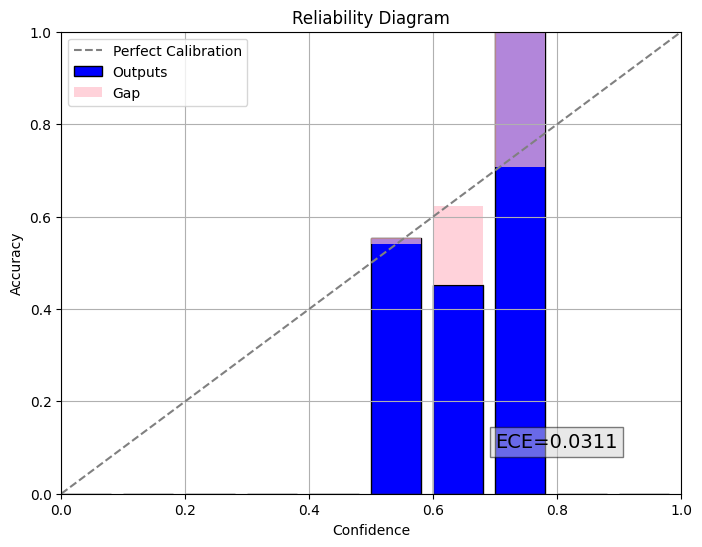

In [23]:
uq_trainer.writer.compute_confidence(uq_trainer.writer.confidence_list, uq_trainer.writer.is_correct_list)